# Recipe Analysis on Reduced Yummly

- Contains an **explorative and graphical data analysis**. Focuses on **number of recipes, ingredients by cuisine, complexity, etc.**.<br> <br>
- Assessment of data quality **Datenqualität** and potential **problemse** and their **solutions** <br> <br> 
- Assesses **similarity** of recipes **on the basis of their ingredients** (e.g. **desserts**, **mains** etc.) <br> <br>  
- Compares the **similarity between cuisines**<br> <br> 
- Looks at relationships between **ingredients** (which "fit" together, i.e., they **appear** overly often **together** by employing a classic (**Market basket Analysis**) <br> <br>  
- **Classification Model** with **cuisine as target** annd **recipes as input**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import math
from collections import Counter
from wordcloud import WordCloud
import random as rd
import os, sys
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
import gc
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import timeit
from tqdm import tqdm


# Don't truncate column lists
pd.options.display.max_columns = None

# Add code path to look for files to import
code_path = os.path.abspath('support')
base_path = os.path.join(code_path, '..')
if code_path not in sys.path:
    sys.path.append(code_path)
    
import ml_utils

%load_ext autoreload
%autoreload 2
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

#variable setting whether precomputed data should be recomputed
#(increases runtime by 2 magnitudes)
rerun = False


2021-08-25 19:33:28.647291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-25 19:33:28.647316: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Exploration

In [2]:
df_X = pd. read_csv('../data/Rezepte/ingredients.csv')
df_y = pd.read_csv('../data/Rezepte/recipes.csv')
df_y.drop_duplicates(['ID'], inplace=True)
data = pd.merge(df_y, df_X, left_on= 'ID', right_on='ID_recipe', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428275 entries, 0 to 428274
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           428275 non-null  int64 
 1   cuisine      428275 non-null  object
 2   ID_recipe    428275 non-null  int64 
 3   ingredients  428275 non-null  object
dtypes: int64(2), object(2)
memory usage: 16.3+ MB


In [3]:
print('Shape of y dataset: {}'.format(df_y.shape))
print('Unique recipes in data: {}'.format(len(np.unique(df_y.ID))))
print('Number of cuisines in dataset: {}'.format(len(np.unique(df_y.cuisine))))
#save unique cusines in vector
unique_cuisines = np.unique(df_y.cuisine)
print('The cuisines are: {}'.format(np.unique(df_y.cuisine)))

df_y.head()

Shape of y dataset: (39774, 2)
Unique recipes in data: 39774
Number of cuisines in dataset: 20
The cuisines are: ['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']


ID      cuisine
0  10259        greek
1  25693  southern_us
2  20130     filipino
3  22213       indian
4  13162       indian

In [4]:
np.unique(df_X.ID_recipe)

array([    0,     1,     2, ..., 49714, 49716, 49717])

In [5]:
print('Shape of X dataset: {}'.format(df_X.shape))
print('Unique ingredients in the dataset: {}'.format(len(np.unique(df_X.ingredients))))

df_X.head()

Shape of X dataset: (428275, 2)
Unique ingredients in the dataset: 6714


ID_recipe      ingredients
0      10259  romaine lettuce
1      10259     black olives
2      10259   grape tomatoes
3      10259           garlic
4      10259           pepper

We need to have a look at the ingredients themselves in order to see how "clean" the data is:

In [6]:
##most frequent ingredients
c = Counter(df_X.ingredients)
c.most_common()[:20]

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113),
 ('green onions', 3078),
 ('tomatoes', 3058),
 ('large eggs', 2948),
 ('carrots', 2814),
 ('unsalted butter', 2782)]

In [7]:
##least frequent ingredients - possibly those with brand names, spelling errors, special subversions of products etc.
c = Counter(df_X.ingredients)
mc = c.most_common()
mc[-30:]

[('puff paste', 1),
 ('Barilla Plus Pasta', 1),
 ('turkey giblet stock', 1),
 ('light chicken stock', 1),
 ('conchiglie', 1),
 ('2% milk shredded mozzarella cheese', 1),
 ('Makers Mark Whisky', 1),
 ('knorr pasta side   cheesi cheddar', 1),
 ('whole grain baguette', 1),
 ('reduced sodium ham', 1),
 ('whole wheat peasant bread', 1),
 ('ranch-style seasoning', 1),
 ('ketjap', 1),
 ('chocolate flavored liqueur', 1),
 ('rotini pasta, cook and drain', 1),
 ('game', 1),
 ('tongue', 1),
 ('Daiya', 1),
 ('curry mix', 1),
 ('Kraft Slim Cut Mozzarella Cheese Slices', 1),
 ('Oscar Mayer Cotto Salami', 1),
 ('Challenge Butter', 1),
 ('orange glaze', 1),
 ('cholesterol free egg substitute', 1),
 ('ciabatta loaf', 1),
 ('Lipton® Iced Tea Brew Family Size Tea Bags', 1),
 ('Hidden Valley® Greek Yogurt Original Ranch® Dip Mix', 1),
 ('lop chong', 1),
 ('tomato garlic pasta sauce', 1),
 ('crushed cheese crackers', 1)]

Compared to the total length of the dataset this looks clean enough to do the visual and frequency analysis before any major data cleaning.  
Consequently, we will prceed with the data introspection


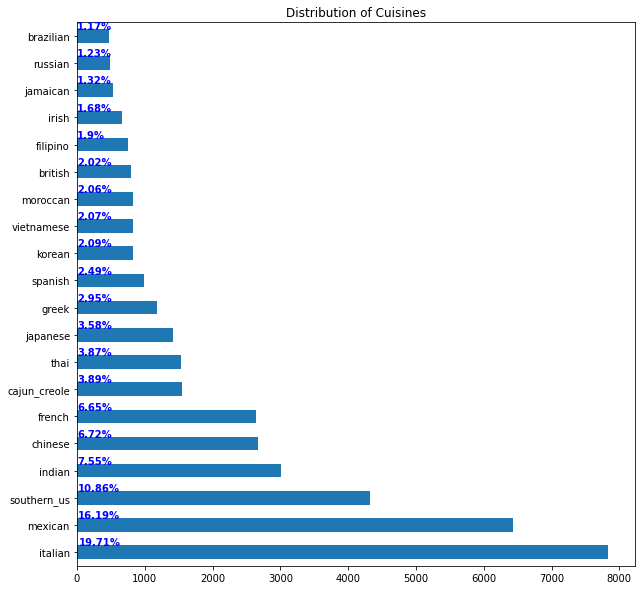

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
per_vals = round(df_y["cuisine"].value_counts(normalize=True)*100, 2)
for i, v in enumerate(per_vals):
    ax.text(v + 3, i + .25, str(v)+"%", color='blue', fontweight='bold')
df_y["cuisine"].value_counts().plot.barh(ax = ax, title = 'Distribution of Cuisines')
plt.show()

<AxesSubplot:title={'center':'50 most common ingredients across cuisines'}>

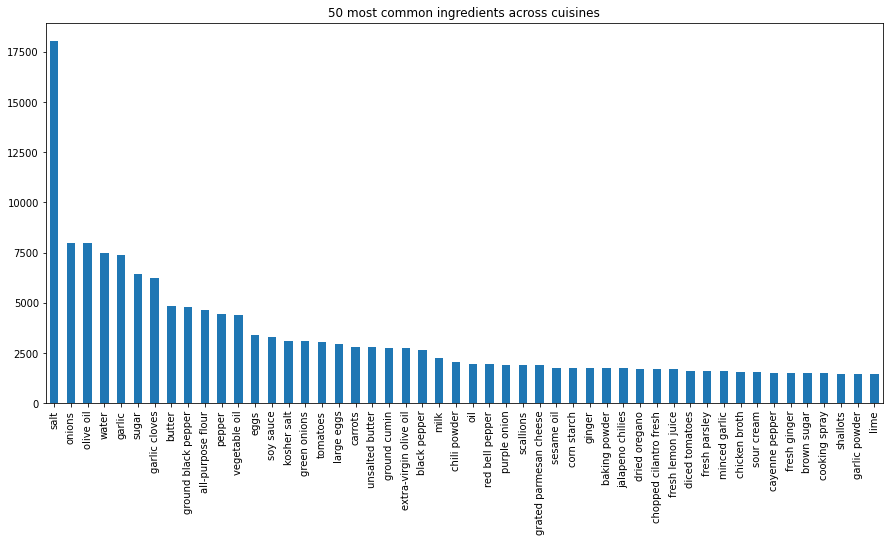

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
        
ing_list_all = df_X.loc[:, 'ingredients']
ing_list_all.value_counts().sort_values(ascending=False).head(50).plot.bar(ax = ax,
                                                                           title='50 most common ingredients across cuisines')



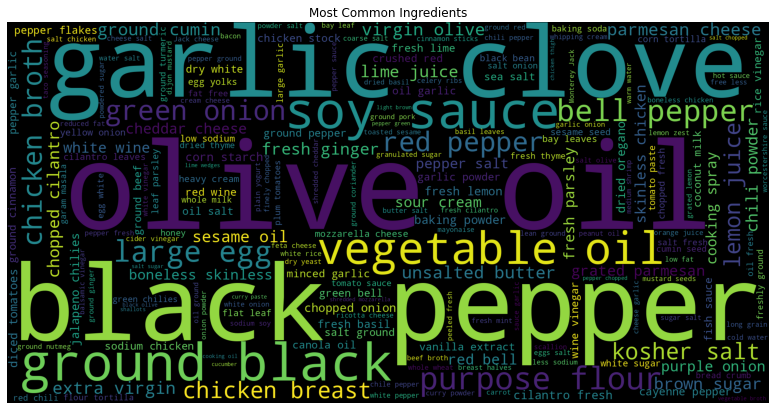

In [10]:
wd = WordCloud(width = 2000, height = 1000)
wd = wd.generate(" ".join(df_X.ingredients))

fig, ax = plt.subplots(figsize=(15,7))
ax.imshow(wd)
ax.set_title("Most Common Ingredients")

plt.axis("off")
plt.show()

### Ingredients by Cuisine:

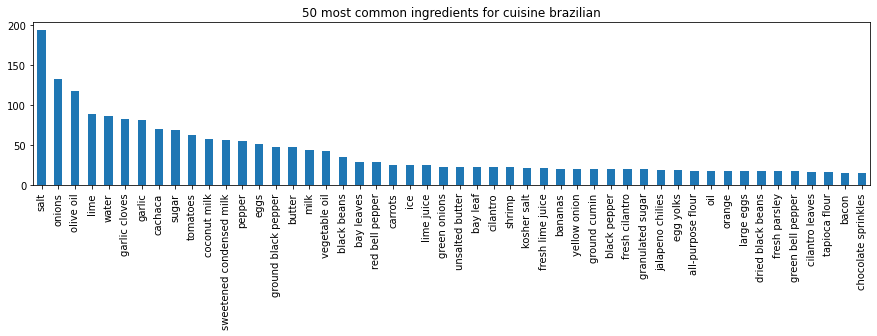

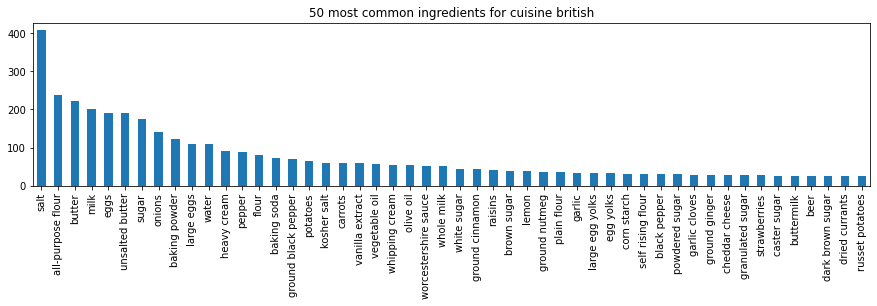

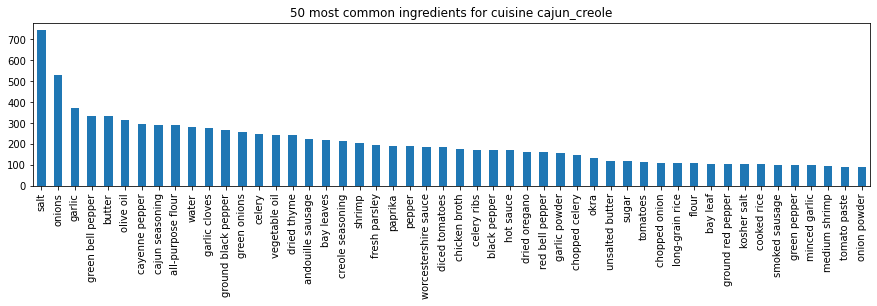

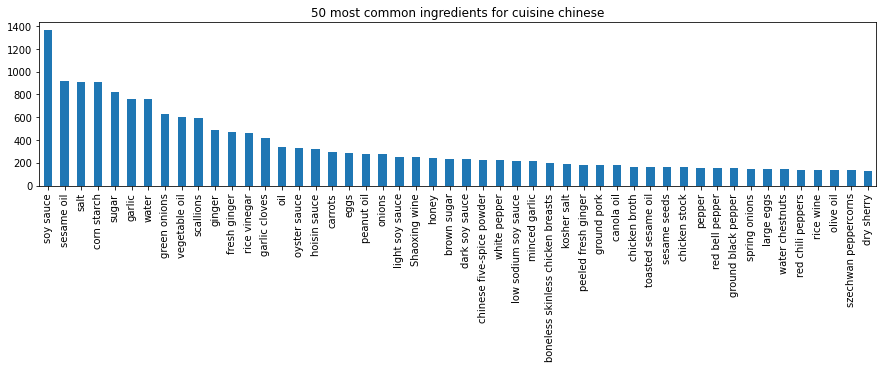

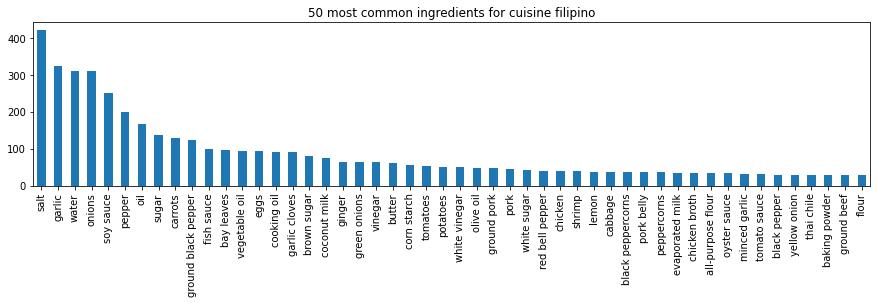

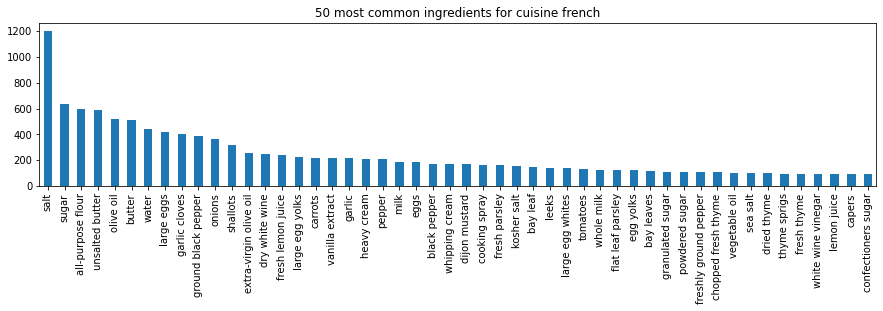

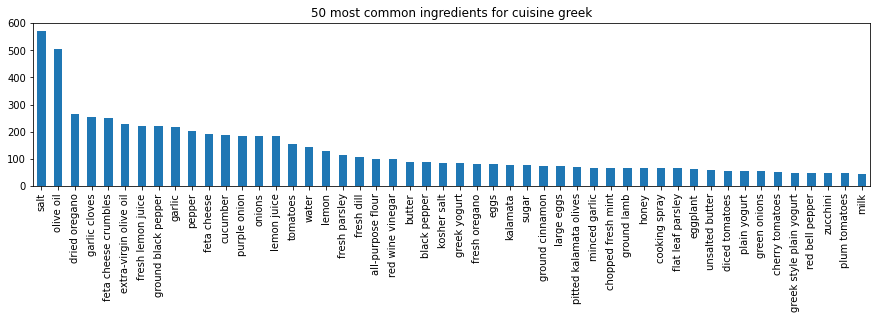

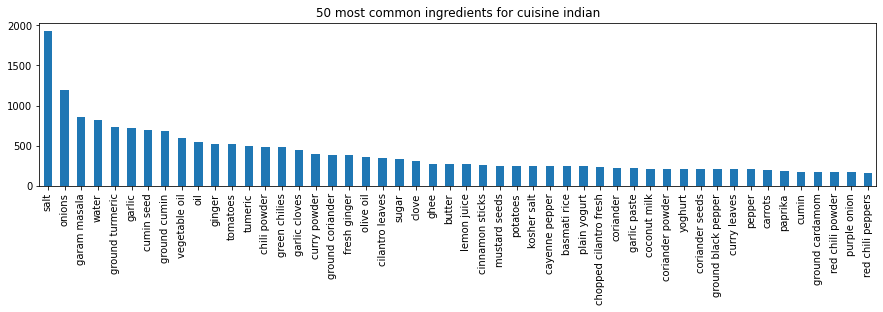

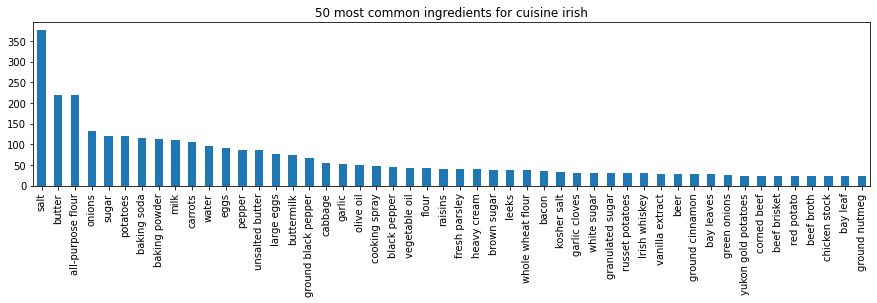

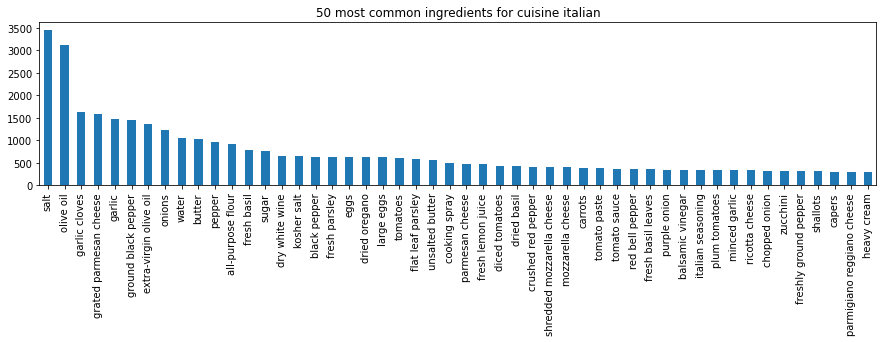

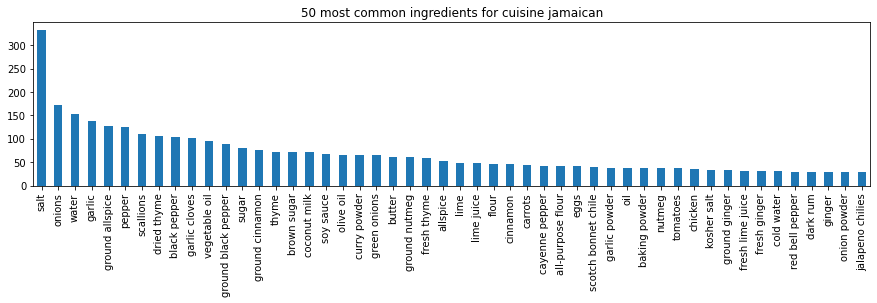

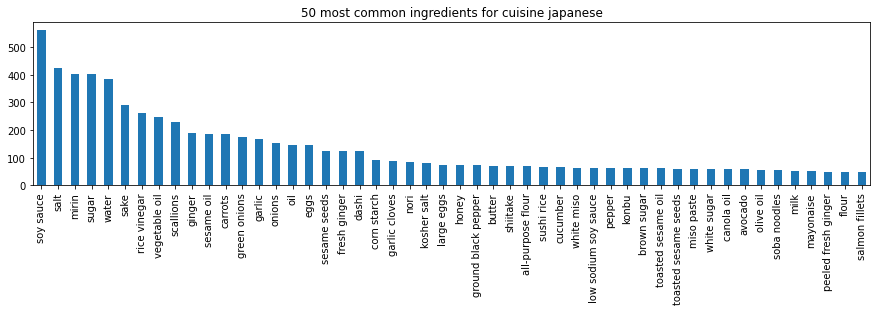

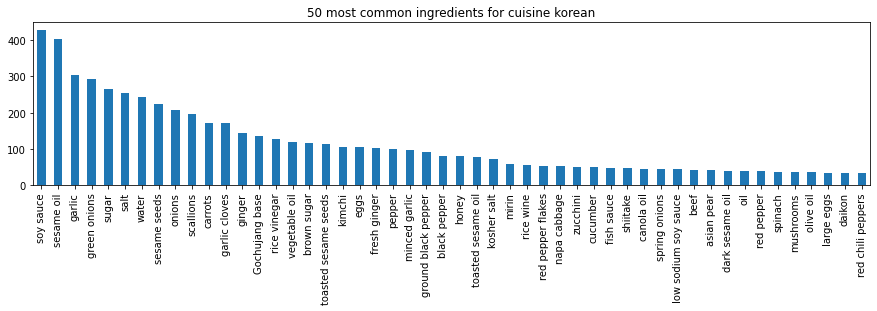

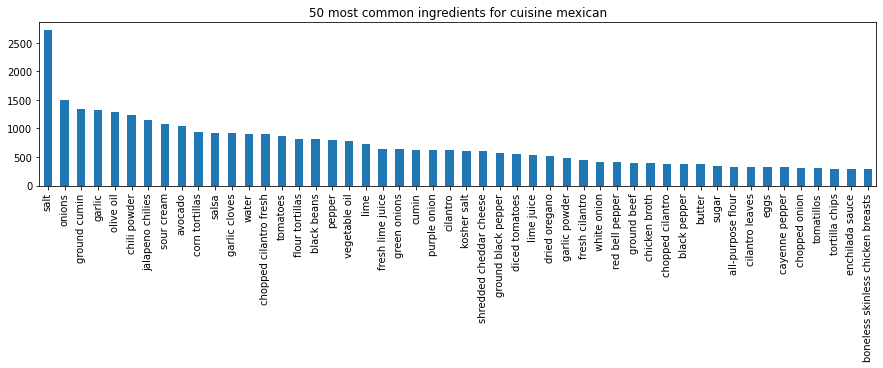

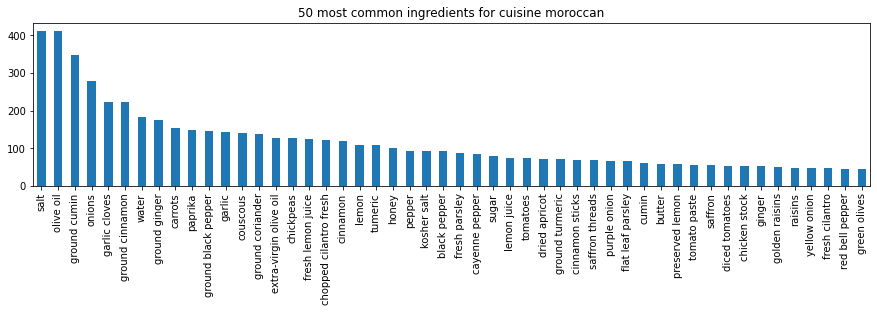

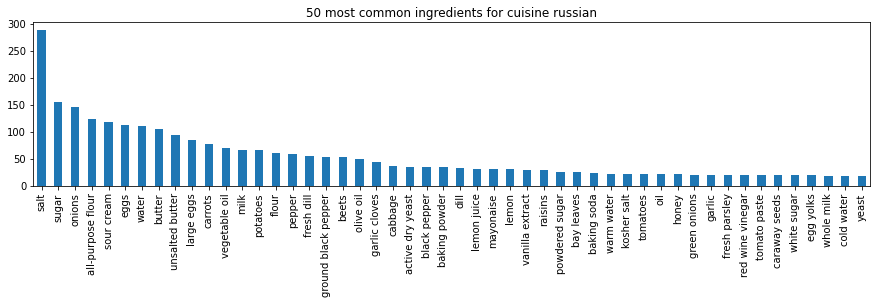

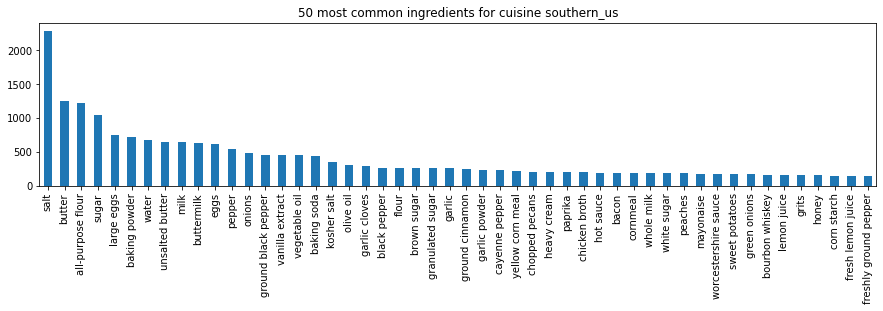

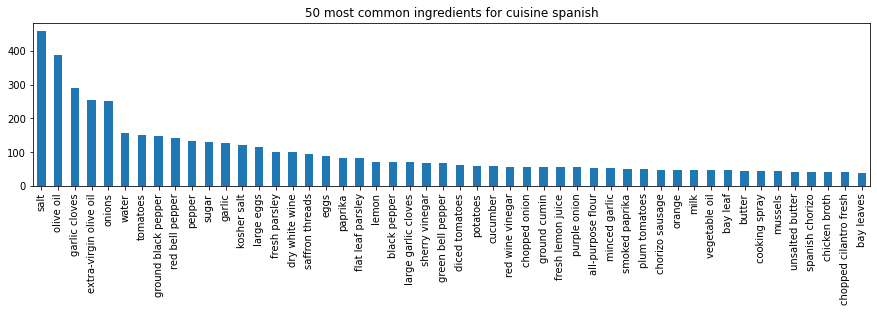

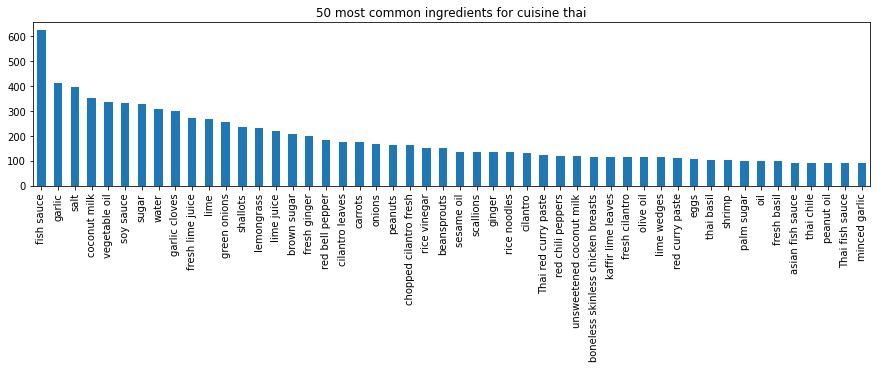

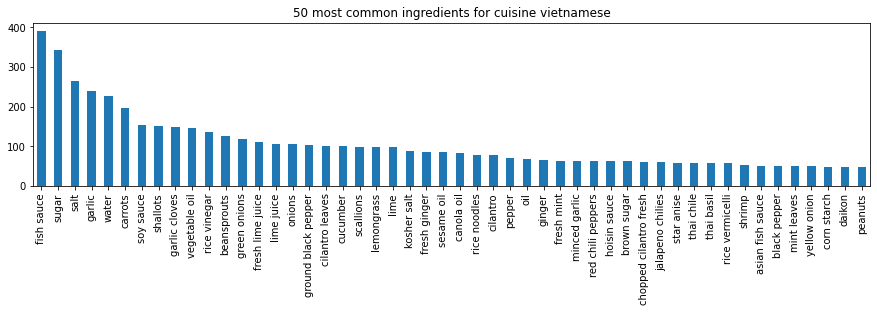

In [11]:
for cuisine in np.unique(data.cuisine):
    fig, ax = plt.subplots(figsize=(15,3))
    cu_i_list = data.loc[data.cuisine==cuisine, 'ingredients']
    cu_i_list.value_counts().sort_values(ascending=False).head(50).plot.bar(ax = ax,
                                                                           title='50 most common ingredients for cuisine {}'.format(cuisine))
    
    plt.show()
    
    

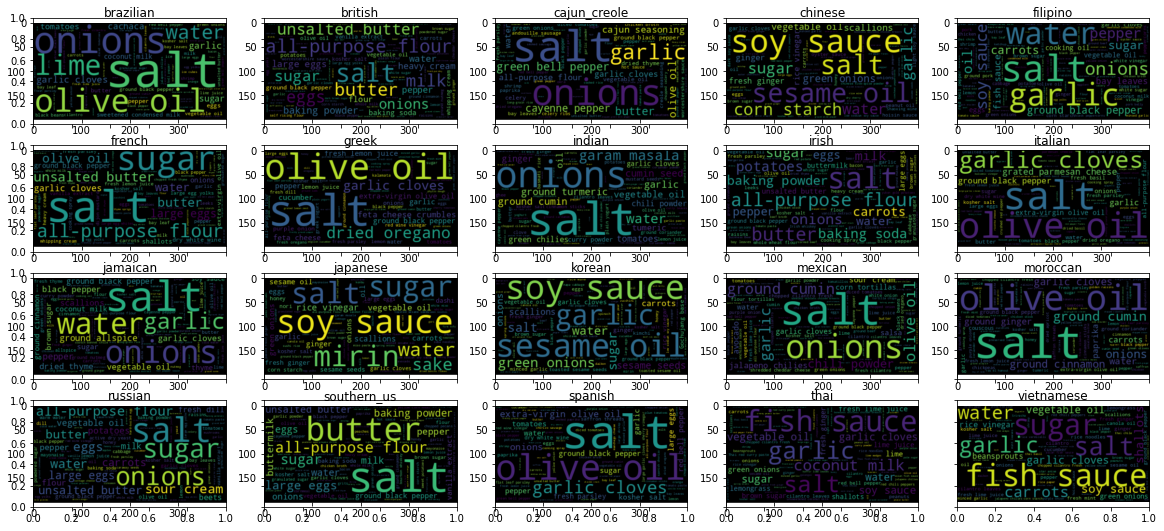

In [12]:
cu_ing = {}
for cuisine in np.unique(data.cuisine):
    cu_ing[cuisine] = Counter()
    indices = (data['cuisine'] == cuisine)
    cu_ing[cuisine].update(data[indices]['ingredients'])



fig, axes = plt.subplots(4, 5, figsize=(20, 9),sharex='col', sharey='row')
for cuisine, ax_index in zip(cu_ing, range(1,21)): 
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=cu_ing[cuisine])
    fig.add_subplot(4, 5, ax_index)    
    plt.title(cuisine)
    plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()




## Complexity of Recipes

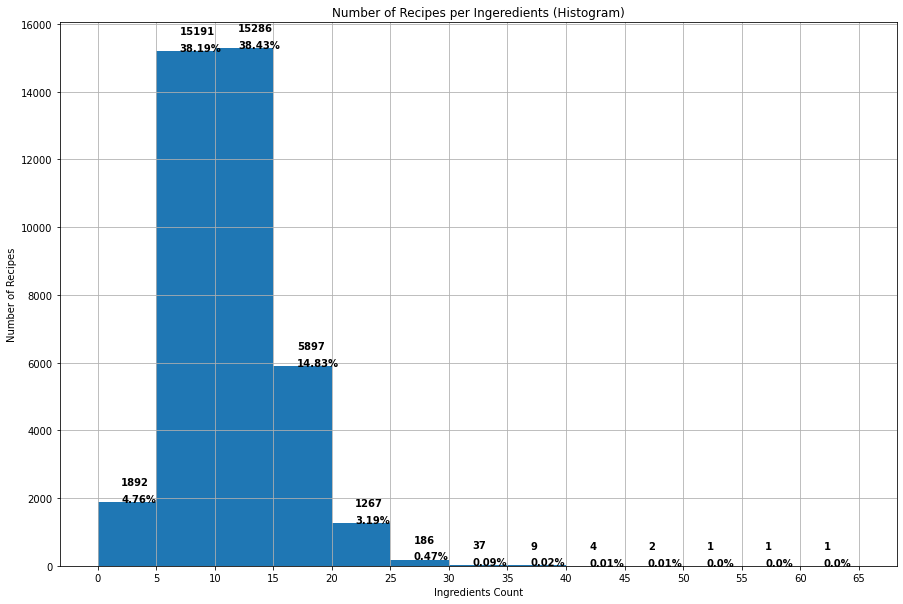

In [13]:
##get max num of ingredients and num of ingredients per recipe
maxi = 0
rec_d = {}
i = 0
for recipe in np.unique(data.ID):
    ingr = data.loc[data.ID == recipe, 'ingredients']
    num = len(ingr)
    rec_d[recipe] = {}
    rec_d[recipe]['ingredients'] = list(ingr)
    rec_d[recipe]['num_ingr'] = num
    if maxi< num:
        maxi = num
        
        
bins = np.arange(0,maxi+5-(maxi%5),5)
dat = [rec_d[key]['num_ingr'] for key in rec_d.keys()]


#calc percentile values
tot_vals = np.histogram(dat, bins)[0]
total = sum(tot_vals, 0.0)
per_vals = np.around((tot_vals / total)*100, 2)
    
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(dat, bins=bins)

for i, v in enumerate(per_vals):
    ax.text(bins[i]+2, tot_vals[i]+1, str(v)+"%", color='black', fontweight='bold')
    ax.text(bins[i]+2, tot_vals[i]+500, str(tot_vals[i]), color='black', fontweight='bold')

ax.set_xlabel('Ingredients Count')
ax.set_ylabel('Number of Recipes')
ax.set_title('Number of Recipes per Ingeredients (Histogram)')
ax.set_xticks(bins) 
#ax.set_xlim([0, maxi+5-(maxi%5)])

plt.grid()
plt.show()  





Over 70% of the dataet consists of less than 20 ingredients. Over half of all recipes have at least 5 and less than 15 ingredients. That begs the question what the outliers at the lower and upper end are:

In [19]:
keys = list(np.unique(dat))
ing_d = dict(zip(keys, [[] for _ in keys]))
lower = 0
upper = 0
for key in rec_d.keys():
    ing_d[rec_d[key]['num_ingr']].append(rec_d[key]['ingredients']+[key]) # add recipe ID at the end of ingredient list
    if rec_d[key]['num_ingr'] <3:
        lower +=1
    elif rec_d[key]['num_ingr'] >=30:
        upper +=1

np.sort(list(ing_d.keys()))



array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 38, 40, 43, 49, 52, 59, 65])

In [20]:
print("There are {} recipes with less than 4 ingredients.".format(lower))
print("There are {} recipes with equal or more than 25.".format(upper))
    

There are 215 recipes with less than 4 ingredients.
There are 55 recipes with equal or more than 25.


Let us have a look at how these "special" recipes are structured

In [22]:
for el in rd.sample([item for sublist in [ing_d[k] for k in ing_d.keys()if k<4] for item in sublist],
                    k=10):
    print('Cuisine {}:     {}'.format(el[-1], ' , '.join(el[1:(len(el))-1])))
    print('The Cusine type is {}'.format(df_y.loc[df_y.ID == el[-1], 'cuisine']))
    print('###################')

Cuisine 27192:     
The Cusine type is 37220    indian
Name: cuisine, dtype: object
###################
Cuisine 29155:     pearl barley , water
The Cusine type is 28018    korean
Name: cuisine, dtype: object
###################
Cuisine 42944:     champagne , peach schnapps
The Cusine type is 32382    southern_us
Name: cuisine, dtype: object
###################
Cuisine 7876:     lime , vodka
The Cusine type is 2691    brazilian
Name: cuisine, dtype: object
###################
Cuisine 23988:     powdered sugar , unsalted butter
The Cusine type is 39437    british
Name: cuisine, dtype: object
###################
Cuisine 42609:     frozen pastry puff sheets , fig jam
The Cusine type is 18293    french
Name: cuisine, dtype: object
###################
Cuisine 36875:     garlic , marsala wine
The Cusine type is 28404    italian
Name: cuisine, dtype: object
###################
Cuisine 39510:     flour
The Cusine type is 4551    cajun_creole
Name: cuisine, dtype: object
###################
Cuis

In [26]:
ids = []
for i, el in enumerate([item for sublist in [ing_d[k] for k in ing_d.keys()if k>=30] for item in sublist]):
    ids.append(el[-1])
    if i<10:
        print('Cuisine {}:     {}'.format(el[-1], ' , '.join(el[1:(len(el))-1])))
        print('The Cusine type is {}'.format(df_y.loc[df_y.ID == el[-1], 'cuisine']))
        print('###################')

Cuisine 6471:     vanilla beans , diced red onions , whole milk , butter , simple syrup , oil , nutmeg , sugar , olive oil , chopped almonds , rosé wine , bitters , jam , fresh parsley , brown sugar , milk , vinegar , baking powder , lemon , salt , garlic cloves , ground cinnamon , black pepper , unsalted butter , flour , cinnamon , vanilla extract , all-purpose flour , whiskey
The Cusine type is 15611    mexican
Name: cuisine, dtype: object
###################
Cuisine 8276:     lime , hoisin sauce , cinnamon , cilantro leaves , carrots , noodles , green cabbage , chicken bones , coriander seeds , shallots , thai chile , yellow onion , celery , cooked chicken breasts , black pepper , fresh ginger , green onions , star anise , hot sauce , beansprouts , peppercorns , rock sugar , water , thai basil , daikon , purple onion , cardamom , chopped cilantro , chicken
The Cusine type is 12843    vietnamese
Name: cuisine, dtype: object
###################
Cuisine 9462:     parmesan cheese , hois

These seem sensible enough. 

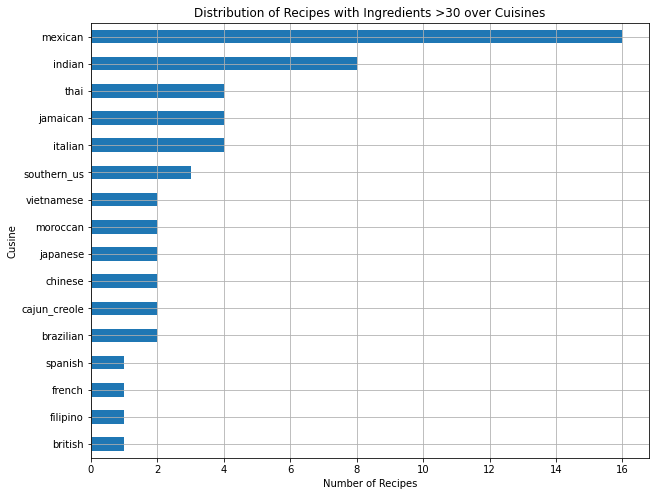

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
df_y[df_y.ID.isin(ids)].groupby(['cuisine']).size().sort_values().plot(kind='barh',
                                                                      ax=ax)
plt.title('Distribution of Recipes with Ingredients >30 over Cuisines')
plt.ylabel('Cusine')
plt.xlabel('Number of Recipes')
plt.grid()
plt.show()

Most recipes with more than 30 ingredients are mexican, the next closest is indian, followed by a more or less even distribution.
  
When looking at the complete dataset, then we get the following distribution:

In [28]:
tmp = {'cuisine': [], 'amount_ingr':[]}
for k in rec_d.keys():
    tmp['cuisine'].append(df_y.loc[df_y.ID == k, 'cuisine'].iloc[0])
    tmp['amount_ingr'].append(rec_d[k]['num_ingr'])
tmp = pd.DataFrame(tmp)
tmp = tmp.groupby(['cuisine']).agg(["mean", "median", "var"])
tmp.columns = tmp.columns.droplevel(0)
tmp.sort_values(by=['median', 'var'], axis=0,ascending=False)




mean  median        var
cuisine                                   
moroccan      12.909866    13.0  23.038207
vietnamese    12.675152    12.0  27.627355
indian        12.705961    12.0  25.168342
jamaican      12.214829    12.0  22.694713
cajun_creole  12.617076    12.0  21.266867
thai          12.545809    12.0  19.463927
chinese       11.982791    12.0  16.338776
korean        11.284337    11.0  15.045713
mexican       10.877446    10.0  21.717307
spanish       10.423660    10.0  17.313245
russian       10.224949    10.0  16.412409
filipino      10.000000    10.0  14.862069
italian        9.909033    10.0  14.491022
greek         10.182128    10.0  13.908880
brazilian      9.520343     9.0  30.859564
japanese       9.735067     9.0  18.027511
british        9.708955     9.0  17.347317
french         9.817838     9.0  17.178903
southern_us    9.634954     9.0  14.972290
irish          9.299850     9.0  13.693739

In [29]:
del rec_d
del ing_d
del lower, upper
gc.collect()

18536

Before we continue, we will now do some data cleaning using the things we have learned so far.<br><br>
1. We will drop all "recipes" with 3 ingredients or less as these do not seem to be valid recipes<br><br>
2. Ingredients, which appear only very seldomly seem to be either those including specific brand names, or those including amounts in oz or ml or some fat-variations of the parent product. We try to rectify those an then drop all ingredients appearing fewer than 20 times<br><br>
3. Some ingredients have spelling mistakes, we try to rectify those
We most likely do not need all the ingredients (overfitting if they only appear once). We assign lower appearance benchmark of 10.


In [30]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [36]:
c = Counter(df_X.ingredients)
tmp = [el[0] for el in c.most_common()[-10:]]

In [37]:
for doc in tmp:
    ann = nlp(doc)
    for ent in ann.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)

Oscar Mayer Cotto Salami 0 24 PERSON
orange glaze 0 12 ORG
cholesterol free egg substitute 0 31 ORG
Hidden Valley 0 13 LOC
Greek Yogurt Original Ranch 15 42 ORG
Dip Mix 44 51 PERSON
chong 4 9 GPE
tomato garlic pasta sauce 0 25 ORG


In [39]:
tmp = [el[0] for el in c.most_common()[:100]]
for doc in tmp:
    ann = nlp(doc)
    for ent in ann.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    

red bell pepper 0 15 ORG
oregano 6 13 GPE
cilantro 8 16 ORG
cayenne pepper 0 14 ORG
green bell pepper 0 17 ORG
cilantro 0 8 ORG
tomato 0 6 ORG
cilantro 0 8 ORG
garam masala 0 12 ORG
tomato sauce 0 12 ORG
plum 0 4 ORG


In [ ]:
These are the manual stopwords as well as spelling fixes we include additionally:

In [42]:
del tmp, nlp
gc.collect()

11587

In [43]:
rerun = False

In [44]:
if os.path.exists('../data/preprocessed/X_br.json') and not rerun:
    X_br = pd.read_json('../data/preprocessed/X_br.json')
    y_br = pd.read_json('../data/preprocessed/y_br.json')
    X_br= X_br.sort_values(by=['ID_recipe'])
    y_br = y_br.sort_values(by=['ID'])
else:
    br = ml_utils.BrandRemover(col='ingredients')
    prep = ml_utils.Preprocessor(idx="ID_recipe", idy="ID", col='ingredients', min_recipe=3)
    X_br = br.transform(df_X)
    X_br, y_br = prep.preprocess(X_br,df_y)
    X_br.to_json('../data/preprocessed/X_br.json')
    y_br.to_json('../data/preprocessed/y_br.json')

In [45]:
if os.path.exists('../data/preprocessed/X_nbr.json') and not rerun:
    X_nbr = pd.read_json('../data/preprocessed/X_nbr.json')
    y_nbr = pd.read_json('../data/preprocessed/y_nbr.json')
    X_nbr= X_nbr.sort_values(by=['ID_recipe'])
    y_nbr = y_nbr.sort_values(by=['ID'])
else:
    prep = ml_utils.Preprocessor(idx="ID_recipe", idy="ID", col='ingredients', min_recipe=3)
    X_nbr, y_nbr = prep.preprocess(df_X.sort_values(by=['ID_recipe']),df_y.sort_values(by=['ID']))
    X_nbr.to_json('../data/preprocessed/X_nbr.json')
    y_nbr.to_json('../data/preprocessed/y_nbr.json')
    

In [46]:
del df_X
del df_y
gc.collect()

0

Now we employ some dimensionality reduction. Then we will feed it to some clustering algorithm in order to see the topology of our data.

In [3]:
ft = ml_utils.Featurizer(idx='ID_recipe',
                        vectorize='ingredients',
                        feat_not_vectorize=['num_ingr'],
                        min_df = 20)
X_one_hot = ft.fit_transform(X_nbr)



In [14]:
X_one_hot


activ dri yeast  adobo sauc  agav nectar  all purpos unbleach flour  \
0                    0           0            0                          0   
1                    0           0            0                          0   
2                    0           0            0                          0   
3                    0           0            0                          0   
4                    0           0            0                          0   
...                ...         ...          ...                        ...   
49712                0           0            0                          0   
49713                0           0            0                          0   
49714                0           0            0                          0   
49716                0           0            0                          0   
49717                0           1            0                          0   

       allpurpos flour  allspic  allspic berri  almond  almond extract  \
0                    0        0              0       0               0   
1                    0        0              0       0               0   
2                    0        0              0       0               0   
3                    0        0              0       0               0   
4                    0        0              0       0               0   
...                ...      ...            ...     ...             ...   
49712                0        0              0       0               0   
49713                0        0              0       0               0   
49714                0        0              0       0               0   
49716                0        0              0       0               0   
49717                0        0              0       0               0   

       almond flour  almond milk  almond past  amaretto  amchur  ancho  \
0                 0            0            0         0       0      0   
1                 0            0            0         0       0      0   
2                 0            0            0         0       0      0   
3                 0            0            0         0       0      0   
4                 0            0            0         0       0      0   
...             ...          ...          ...       ...     ...    ...   
49712             0            0            0         0       0      0   
49713             0            0            0         0       0      0   
49714             0            0            0         0       0      0   
49716             0            0            0         0       0      0   
49717             0            0            0         0       0      0   

       ancho chili pepper  anchovi  anchovi past  anchovi raw fish  and  \
0                       0        0             0                 0    0   
1                       0        0             0                 0    0   
2                       0        0             0                 0    0   
3                       0        0             0                 0    0   
4                       0        0             0                 0    0   
...                   ...      ...           ...               ...  ...   
49712                   0        0             0                 0    0   
49713                   0        0             0                 0    0   
49714                   0        0             0                 0    0   
49716                   0        0             0                 0    0   
49717                   0        0             0                 0    0   

       andouil sausag  angel hair  anis  anis seed  appl  appl cider  \
0                   0           0     0          0     0           0   
1                   0           0     0          0     0           0   
2                   0           0     0          0     0           0   
3                   0           0     0          0     0           0   
4                   0          

In [15]:
if os.path.exists('../data/preprocessed/X_tsne.npy') and not rerun:
    red_data = np.load('../data/preprocessed/X_tsne.npy')
    with open('../data/preprocessed/tsne.p', 'rb') as handle:
        tsne = pickle.load(handle)
else:
    red_data, tsne, kl = ml_utils.get_tsne(X_one_hot.iloc[:, 0:(X_one_hot.shape[1]-1)],
                                          learning_rate=15, perplexity=80)
    
    np.save('../data/preprocessed/X_tsne.npy', red_data)
    with open('../data/preprocessed/tsne.p', 'wb') as handle:
        pickle.dump(tsne, handle)

Now we plot a scatter plot for the SVD reduction over cusines:

{'brazilian': 'rosybrown', 'jamaican': 'salmon', 'mexican': 'black', 'southern_us': 'darkred', 'cajun_creole': 'indianred', 'spanish': 'orangered', 'moroccan': 'yellow', 'french': 'tan', 'british': 'darkviolet', 'irish': 'fuchsia', 'italian': 'orange', 'greek': 'gold', 'russian': 'darkkhaki', 'indian': 'lime', 'thai': 'mediumspringgreen', 'vietnamese': 'mediumturquoise', 'chinese': 'darkcyan', 'japanese': 'aqua', 'korean': 'cadetblue', 'filipino': 'dodgerblue'}


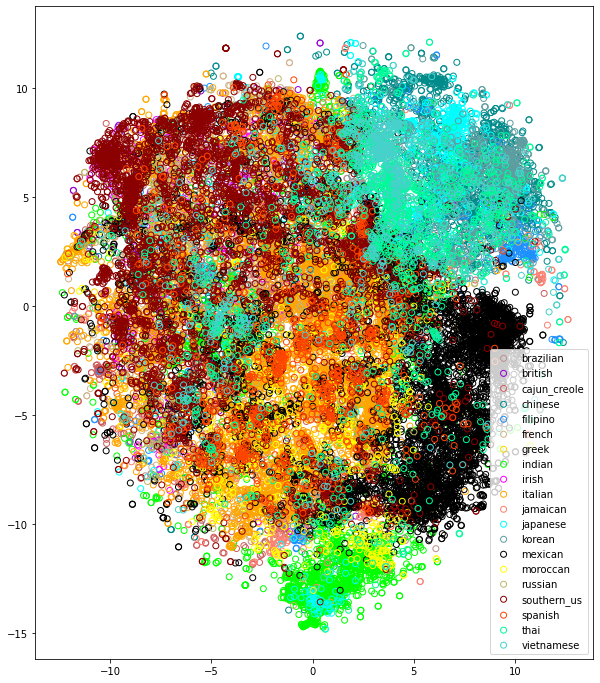

In [16]:
ml_utils.plot_scatter_cuisines(red_data, y_nbr.cuisine)

This does not look too good. Even when we use SVD before (reduction to 50 features before tsne reduction to 2) the results do not look good - they look worse. That is intereseting as SVD should be - mathematically speaking - the correct choice here. However, as it is not working we try the alternative tSNE below:

{'brazilian': 'rosybrown', 'jamaican': 'salmon', 'mexican': 'black', 'southern_us': 'darkred', 'cajun_creole': 'indianred', 'spanish': 'orangered', 'moroccan': 'yellow', 'french': 'tan', 'british': 'darkviolet', 'irish': 'fuchsia', 'italian': 'orange', 'greek': 'gold', 'russian': 'darkkhaki', 'indian': 'lime', 'thai': 'mediumspringgreen', 'vietnamese': 'mediumturquoise', 'chinese': 'darkcyan', 'japanese': 'aqua', 'korean': 'cadetblue', 'filipino': 'dodgerblue'}


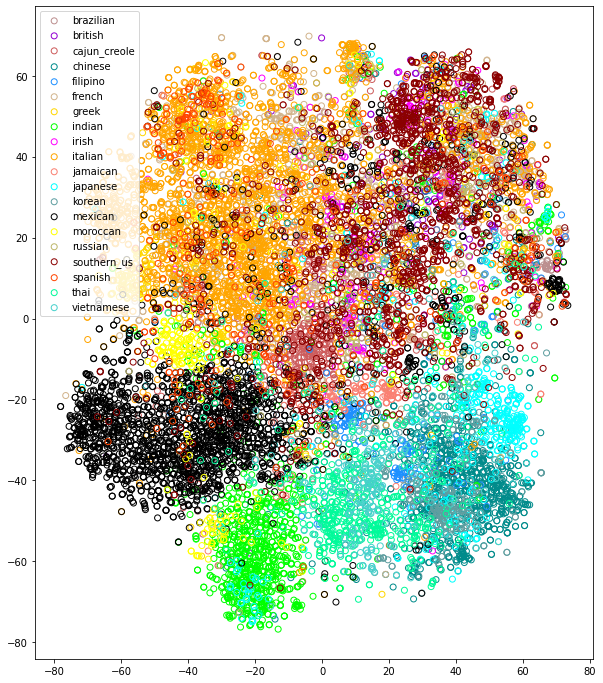

In [47]:
if os.path.exists('../data/preprocessed/X_cosine.npy') and not rerun:
    X_to_reduce = np.load('../data/preprocessed/X_cosine.npy')
else:
    X_to_reduce = squareform(pdist(X_one_hot.iloc[:, 0:(X_one_hot.shape[1]-1)], metric='cosine'))
    np.save('../data/preprocessed/X_cosine.npy', X_to_reduce)

if os.path.exists('../data/preprocessed/X_tsne_cosine.npy') and not rerun:
    res = np.load('../data/preprocessed/X_tsne_cosine.npy')
else:
    tsne2 = TSNE(metric='precomputed', random_state=1234567)
    res = tsne2.fit_transform(X_to_reduce[0:15000, 0:15000])
    np.save('../data/preprocessed/X_tsne_cosine.npy', res)
y_res = y_nbr.cuisine[0:15000]
ml_utils.plot_scatter_cuisines(res, y_res)

We can see, that different cuisines form distinctive clusters. Moreover, cusines which are "closer" geographically are also closer in the decomposed space.

In [48]:
X_cosine2 = squareform(pdist(res, metric='cosine')) ##this is for the similarity heatmap

Now we plot the reduced form for all cuisine groups separately in order to see the similarity between cusines. Moreover, we also show the average unnormalized cosine similiarity matrix (similarity with self is set to 0):

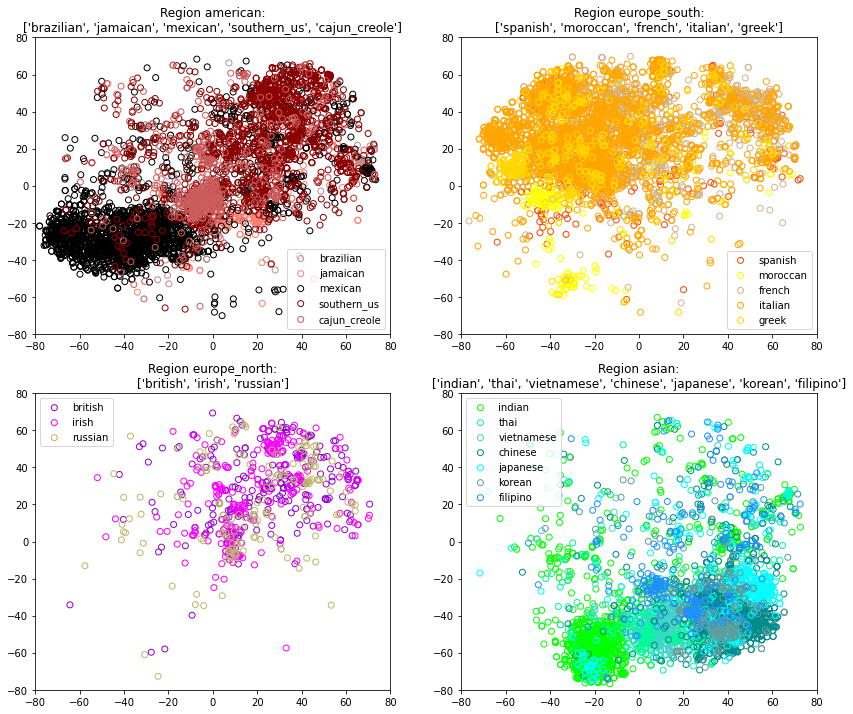

Confusion matrix, without normalization
<class 'NoneType'>


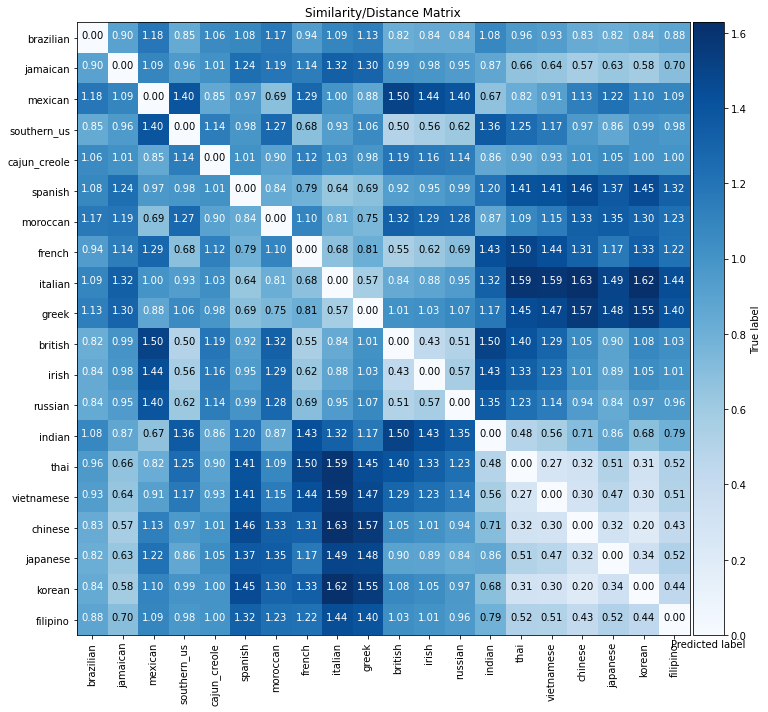

In [43]:
##plot the different regions into separate plots to see how good the separation really is.
region_dic, regions = ml_utils.get_regions()
reg_names = list(regions.keys())
all_cuisines = [regions[reg] for reg in reg_names]
all_cuisines = [item for sublist in all_cuisines for item in sublist]
fig, ax = plt.subplots(nrows=2, ncols = math.ceil(len(reg_names)/2), figsize=(14,12))
#runners
i=0
j=0
c0=0
c1=0
##make an average siiarity matrix for each cusine
simil = np.zeros((len(region_dic.keys()), len(region_dic.keys())))
classes = []

for k, reg in enumerate(reg_names):    
    mask =  y_res.isin(regions[reg])
    ax[i,j] = ml_utils.plot_scatter_cuisines(res[mask], y_res[mask],
                                             ax=ax[i,j], sublabs = regions[reg])
    
    regionsstring = [el +"\n" if c%4==0 else el for c, el in enumerate(regions[reg]) ]
    ax[i,j].set_title('Region {}:\n{}'.format(reg, regions[reg]))
    ax[i,j].set_xlim(-80,80)
    ax[i,j].set_ylim(-80,80)
    ax[i,j].legend()
    
    if j<math.ceil(len(reg_names)/2)-1:
        j+=1
    else:
        i+=1
        j=0
        
    #fill average simiarity matrix by regions
    for cus in regions[reg]:
        rowm = np.array(y_nbr.cuisine[0:15000]==cus)
        for other in all_cuisines:
            if cus == other:
                c1 +=1
                continue
            colm = np.array(y_nbr.cuisine[0:15000]==other)
            #simil[c0, c1] = X_to_reduce[0:15000, 0:15000][np.ix_(rowm, colm)].mean(axis=1).mean()
            simil[c0, c1] = X_cosine2[0:15000, 0:15000][np.ix_(rowm, colm)].mean(axis=1).mean() 
            c1 +=1
        c0 +=1
        c1 = 0
    

        
plt.show()

#plot the cosine similarities as a heat map
ml_utils.plot_confusion_matrix(simil, all_cuisines, title='Similarity/Distance Matrix')
del simil


        
    

If we cluster the data, we get the following result:

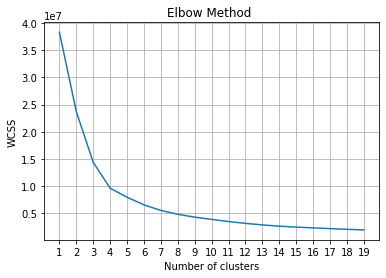

In [20]:
wcss = ml_utils.get_kmeans_wcss(res)

Best number of cluster is somewhere between 3 and 5

In [21]:
clusters, kmeans_o = ml_utils.kmeans(res, 5)
y_res = y_nbr[0:15000].copy(deep=True)
y_res['clusters'] = clusters
cluster_distr = {}
for clus in np.unique(clusters):
    cluster_distr[clus] = Counter(y_res[y_res.clusters==clus].cuisine)

In [22]:
for key, item in cluster_distr.items():
    print('Cluster {} consists of the following:'.format(key))
    print(item.most_common(6))
    print('\n\n')

Cluster 0 consists of the following:
[('italian', 1798), ('french', 348), ('greek', 271), ('spanish', 177), ('southern_us', 110), ('mexican', 89)]



Cluster 1 consists of the following:
[('chinese', 935), ('thai', 504), ('japanese', 392), ('korean', 275), ('vietnamese', 259), ('filipino', 154)]



Cluster 2 consists of the following:
[('southern_us', 935), ('italian', 496), ('french', 424), ('mexican', 267), ('british', 180), ('indian', 125)]



Cluster 3 consists of the following:
[('mexican', 1875), ('indian', 835), ('moroccan', 176), ('thai', 62), ('southern_us', 54), ('japanese', 46)]



Cluster 4 consists of the following:
[('italian', 620), ('southern_us', 467), ('cajun_creole', 411), ('french', 203), ('mexican', 152), ('irish', 107)]





Let us see what the central ingredients in each cuisne are and how the relate with each other:

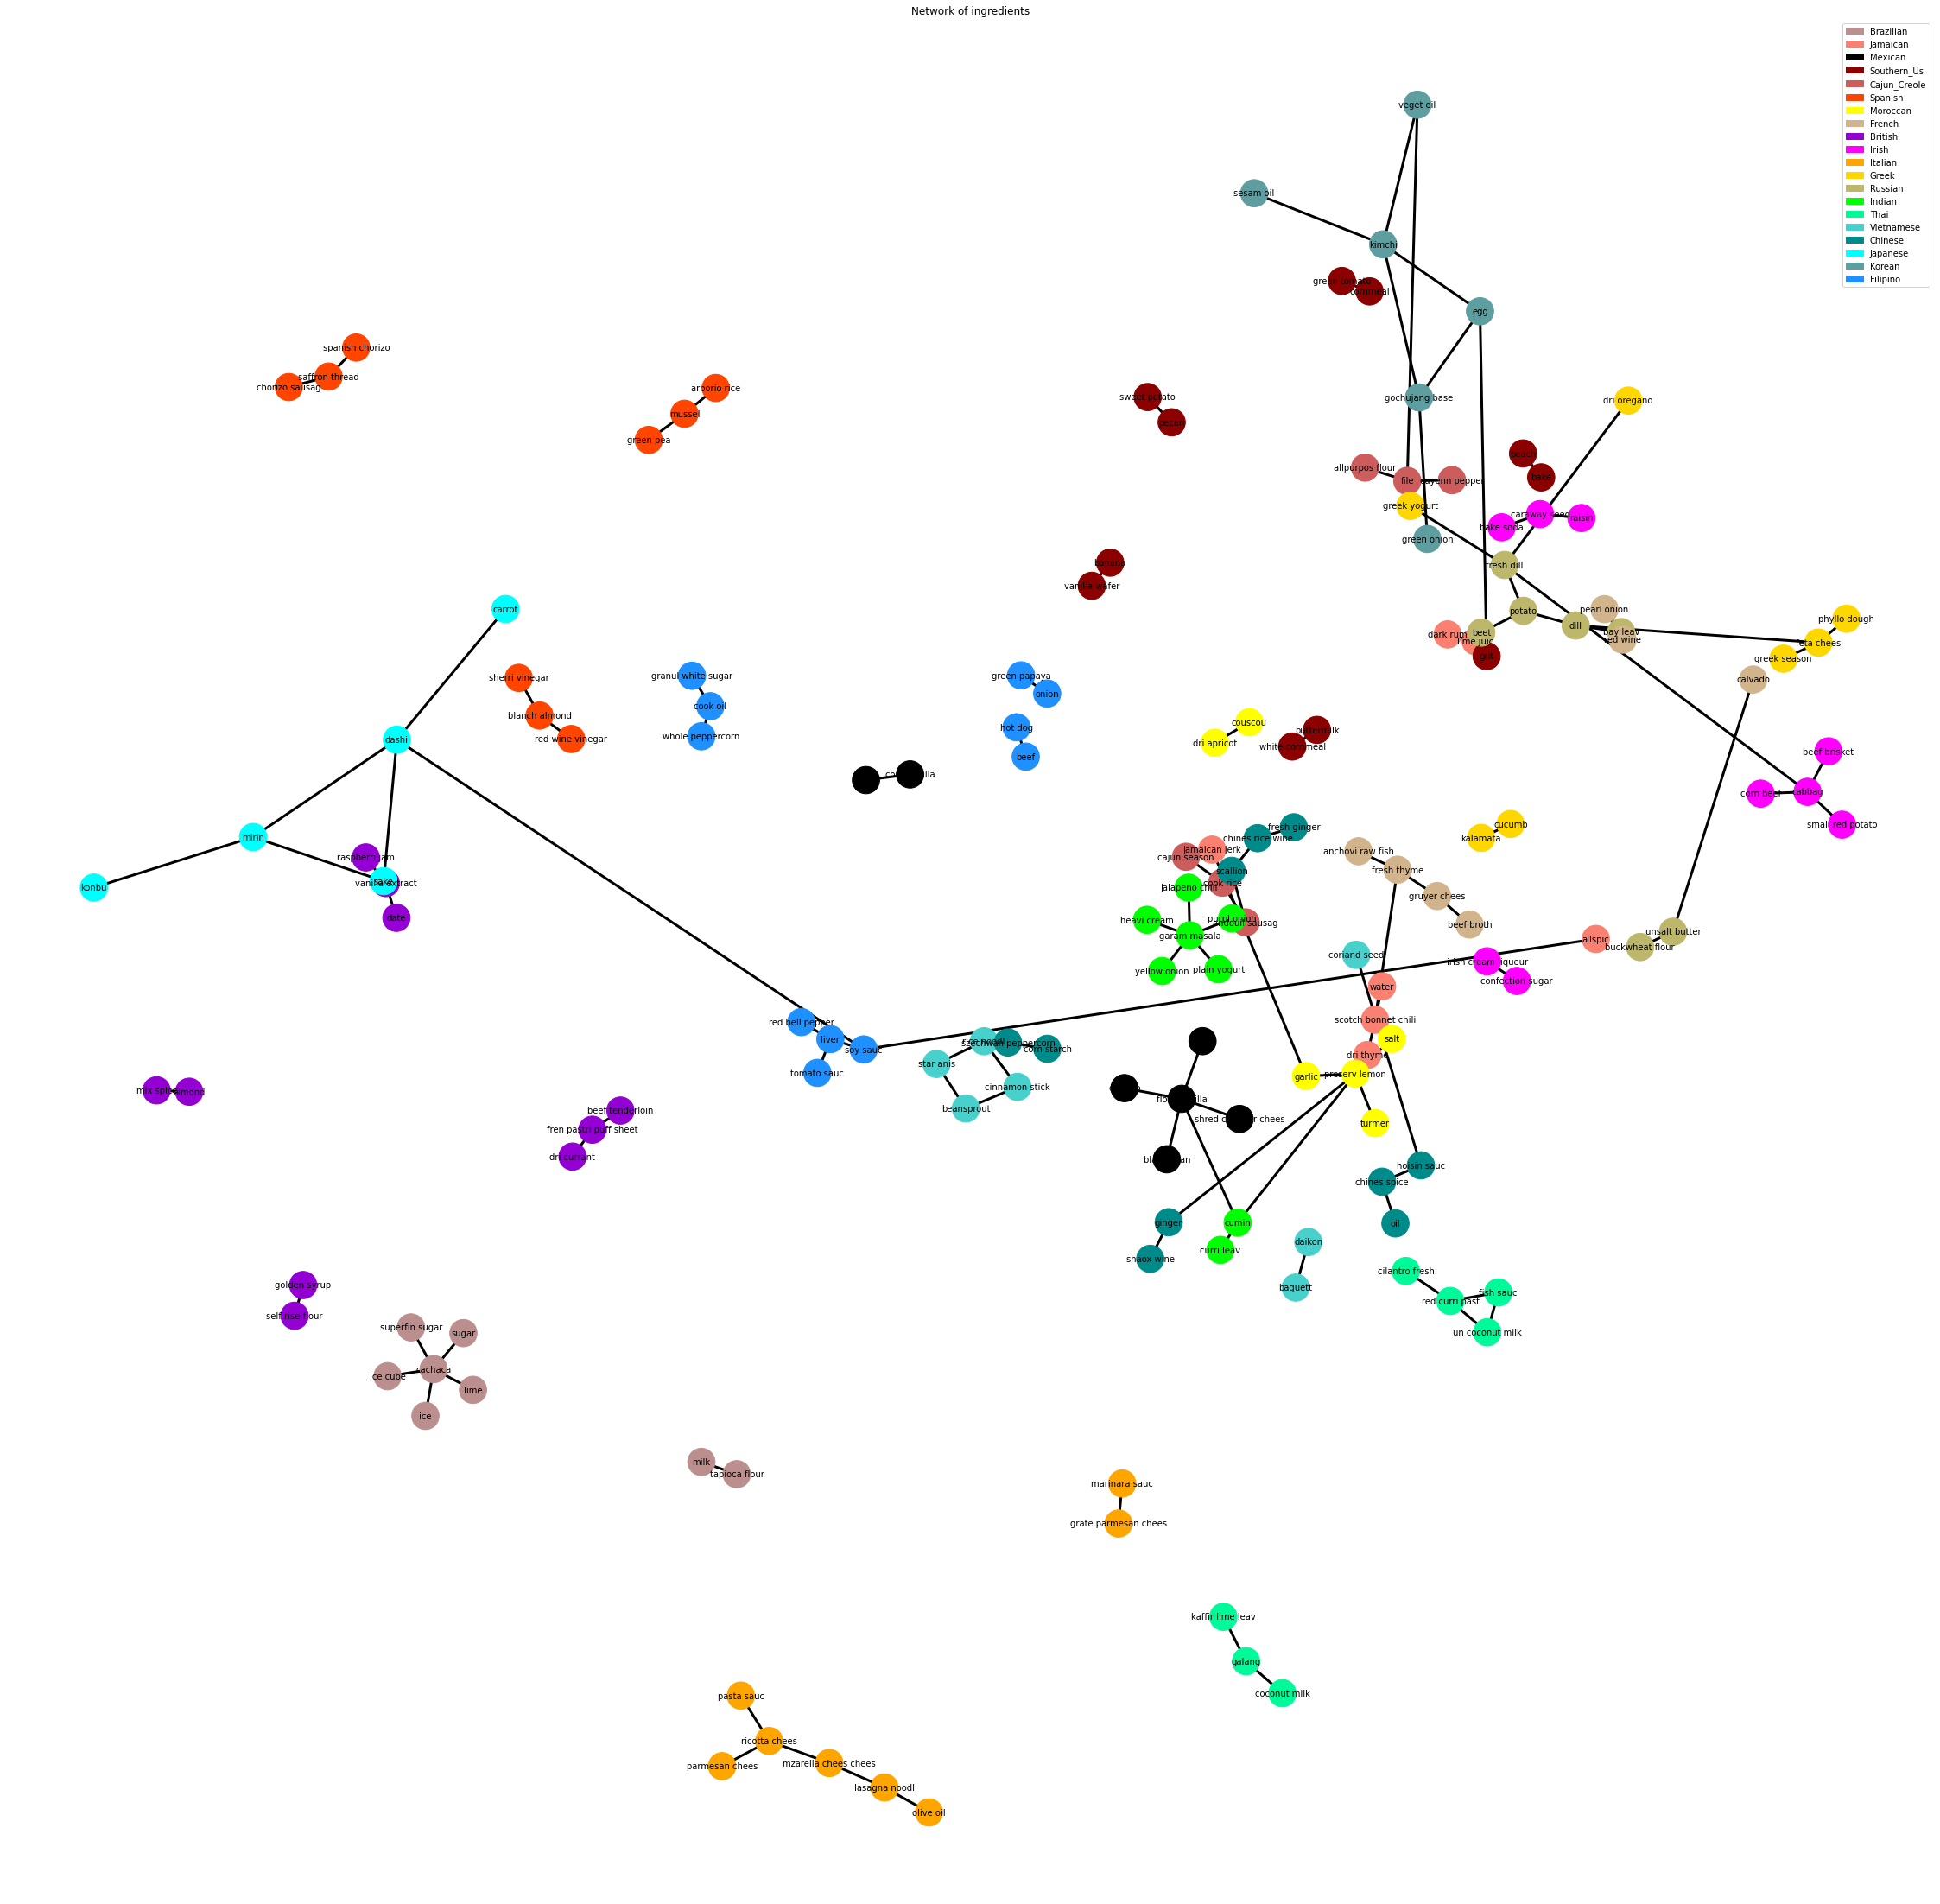

In [23]:
ml_utils.build_ingredient_graph(X_nbr, y_nbr,
                                np.array(X_one_hot.iloc[:, 0:(X_one_hot.shape[1]-1)]),
                                         ft.vectorizer)

## Finding Groups of Dishes within Cuisines

In the following, we look at each cuisine separately in order to find pssoble groups of dishes. To this end, we use the reduced and downscaled data from before and redo the analysis of the clustering. For the network-graph, we will use the clusters as labels.

In [ ]:
##make it for all cusines separately as dishes should vary quite a bit wthin cusines
cuisines = y_nbr.cuisine[0:15000].unique()
reduced_data = {}
for cus in cuisines:
    #get bool vector
    mask = y_nbr[0:15000].cuisine == cus
    dat = X_to_reduce[0:15000, 0:15000][np.ix_(mask, mask)]
    red_tmp = TSNE(metric='precomputed', random_state=1234567,
                   square_distances=True).fit_transform(dat)
    wcss_t = ml_utils.get_kmeans_wcss(red_tmp, n_limit=8, title=cus)
    reduced_data[cus] = red_tmp

del X_to_reduce
gc.collect()

Lets use the found cluster to cluster the recipes and then plot the network graphs.

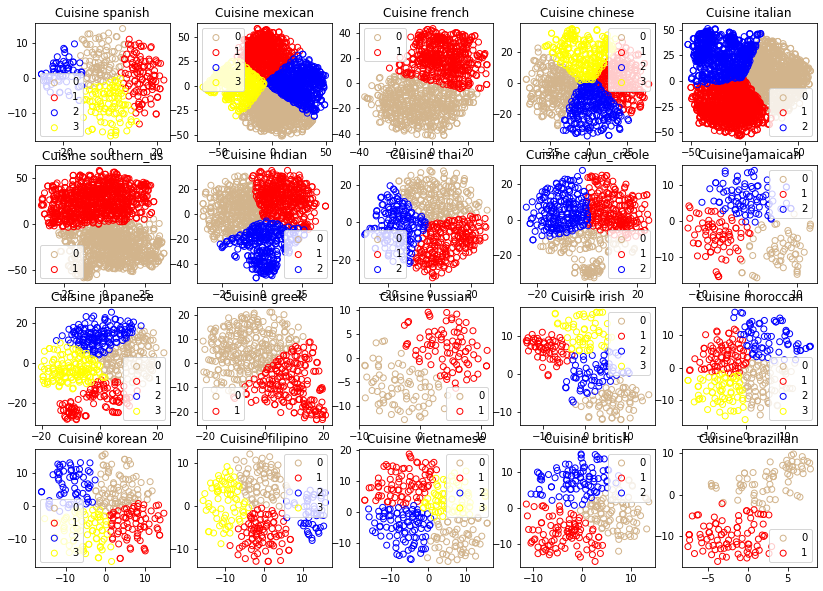

In [25]:
#get num clusters from elbow-plots
clusternum_dic ={
    'spanish': 4,
    'mexican': 4,
    'french': 2,
    'chinese': 4,
    'italian': 3,
    'southern_us': 2,
    'indian': 3,
    'thai': 3,
    'cajun_creole': 3,
    'jamaican': 3,
    'japanese': 4,
    'greek':2,
    'russian':2,
    'irish': 4,
    'moroccan': 4,
    'korean': 4,
    'filipino':4,
    'vietnamese':4,
    'british':3,
    'brazilian':2,
}
cluster_dic = {}
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,10))
i=0
j=0
for cus in cuisines:
    num_clust = clusternum_dic[cus]
    
    clusters, km = ml_utils.kmeans(reduced_data[cus], num_clust)
    cluster_dic[cus] = clusters
    ax[i,j] = ml_utils.plot_scatter_cuisines(reduced_data[cus],
                                             clusters,
                                             ax=ax[i,j], palette={0:'tan',
                                                                 1:'red',
                                                                 2:'blue',
                                                                 3:'yellow',
                                                                 4:'green',
                                                                 5:'fuchsia'})
    
    
    ax[i,j].set_title('Cuisine {}'.format(cus))
    #ax[i,j].set_xlim(-80,80)
    #ax[i,j].set_ylim(-80,80)
    ax[i,j].legend()
    
    if j<math.ceil(len(cuisines)/4)-1:
        j+=1
    else:
        i+=1
        j=0
plt.show()


So, we find somewhat sensible cluster - not for all cuisines but for some. Now we look at the most-used ingredients for each cluster to see whether we can guess which dishes are mainly part of that cluster:

In [11]:
#Top Ingredients per Cluster
one_tmp = X_one_hot.iloc[0:15000, 0:(X_one_hot.shape[1]-1)]
y_tmp = y_nbr.iloc[0:15000].copy(deep=True)
X_tmp = X_nbr.iloc[0:15000]

for cus in cuisines:
    print('Looking at Cuisine {}'.format(cus))
    clust = cluster_dic[cus]
    for clus in np.unique(clust):
        tmp = one_tmp[list(y_tmp.cuisine == cus)][(clust == clus)].sum(axis=0)
        c = Counter({k:v for k,v in zip(tmp.index.values, tmp.values)})

        print('Cluster {} consists of the following:'.format(clus))
        print(c.most_common(10))
        print('\n')
    print('###########################################################')
del c, tmp
gc.collect()

Looking at Cuisine spanish
Cluster 0 consists of the following:
[('olive oil', 53), ('salt', 49), ('onion', 44), ('egg', 43), ('pepper', 27), ('garlic', 24), ('black pepper', 20), ('garlic clove', 17), ('tomato', 17), ('kosher salt', 16)]


Cluster 1 consists of the following:
[('olive oil', 64), ('garlic clove', 52), ('onion', 52), ('salt', 42), ('black pepper', 33), ('garlic', 24), ('green bell pepper', 22), ('tomato', 22), ('red bell pepper', 21), ('cumin', 18)]


Cluster 2 consists of the following:
[('extravirgin olive oil', 90), ('garlic clove', 70), ('salt', 43), ('red bell pepper', 25), ('black pepper', 23), ('onion', 21), ('kosher salt', 19), ('flat leaf parsley', 18), ('sherri vinegar', 18), ('fresh lemon juic', 17)]


Cluster 3 consists of the following:
[('sugar', 35), ('salt', 27), ('egg', 24), ('milk', 19), ('lemon', 16), ('orang', 15), ('water', 15), ('olive oil', 13), ('cinnamon stick', 11), ('egg yolk', 11)]


###########################################################

Cluster 1 consists of the following:
[('soy sauc', 35), ('salt', 33), ('garlic clove', 32), ('black pepper', 27), ('sugar', 27), ('scallion', 26), ('sesam oil', 25), ('onion', 22), ('veget oil', 22), ('pepper', 21)]


Cluster 2 consists of the following:
[('garlic', 40), ('onion', 28), ('water', 27), ('green onion', 25), ('sugar', 23), ('ginger', 19), ('napa cabbag', 19), ('scallion', 19), ('soy sauc', 17), ('kosher salt', 15)]


Cluster 3 consists of the following:
[('soy sauc', 69), ('sesam oil', 46), ('brown sugar', 41), ('green onion', 40), ('garlic', 37), ('garlic clove', 28), ('water', 23), ('salt', 22), ('ginger', 20), ('carrot', 18)]


###########################################################
Looking at Cuisine filipino
Cluster 0 consists of the following:
[('salt', 73), ('onion', 70), ('garlic', 65), ('pepper', 58), ('water', 41), ('oil', 38), ('fish sauc', 30), ('ginger', 19), ('carrot', 17), ('tomato', 16)]


Cluster 1 consists of the following:
[('water', 44), ('soy sauc'

67

Very obviously there are savory and sweet clusters. Also for some cuisines we find clusters which hold starters or fishy dishes.

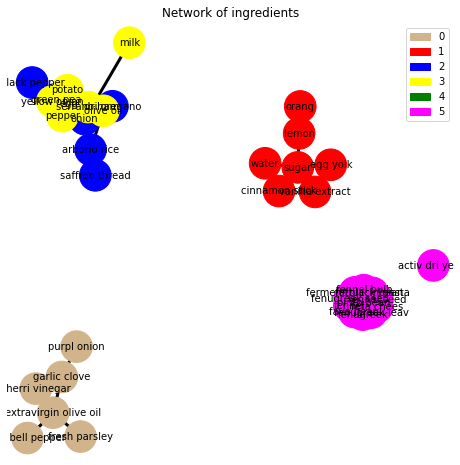

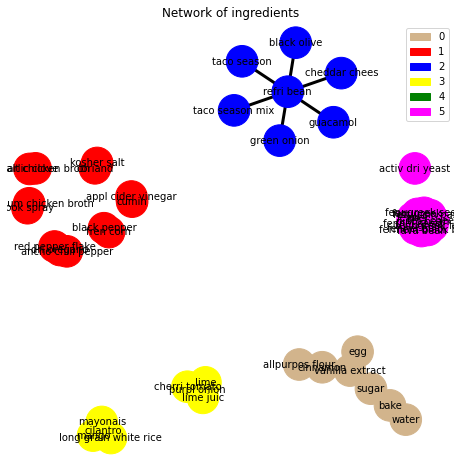

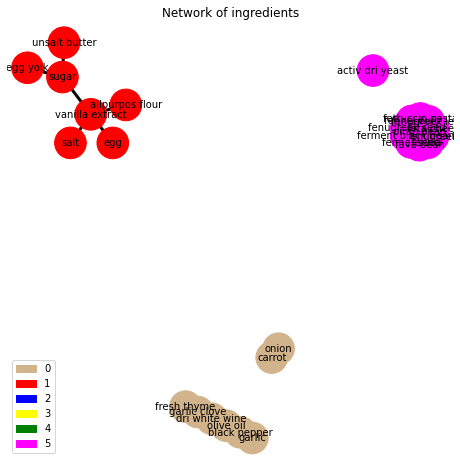

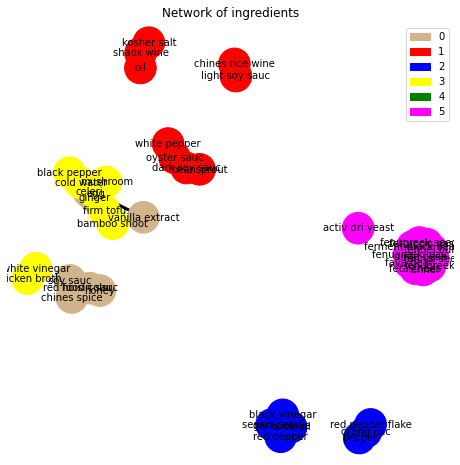

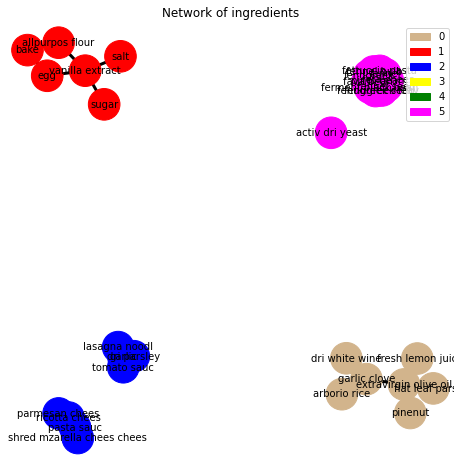

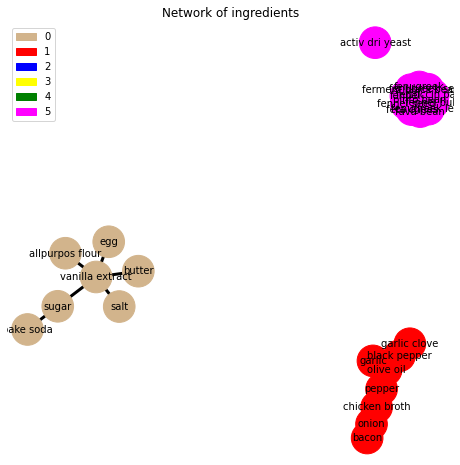

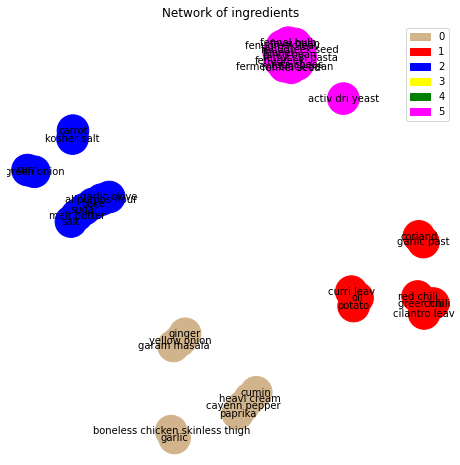

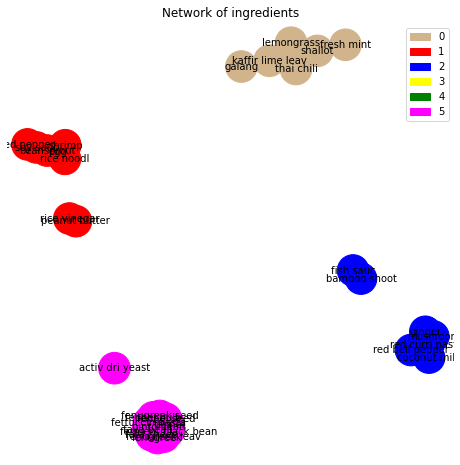

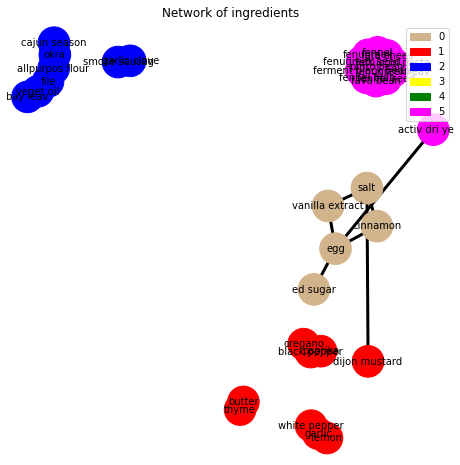

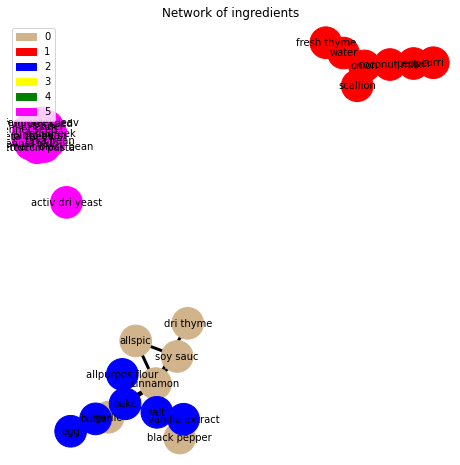

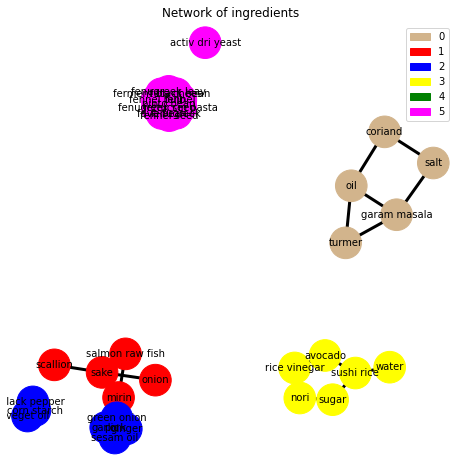

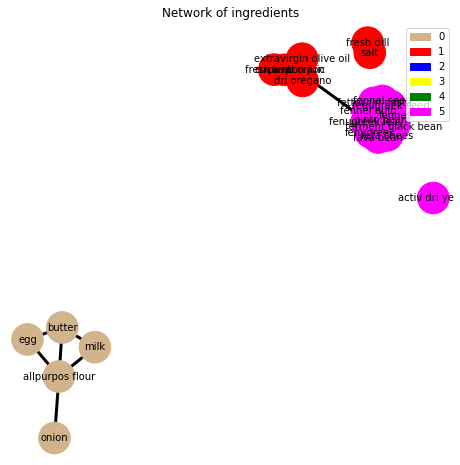

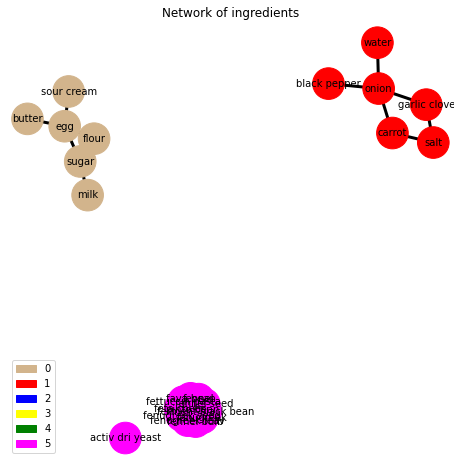

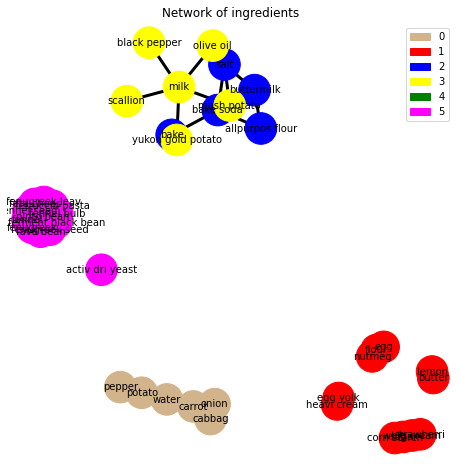

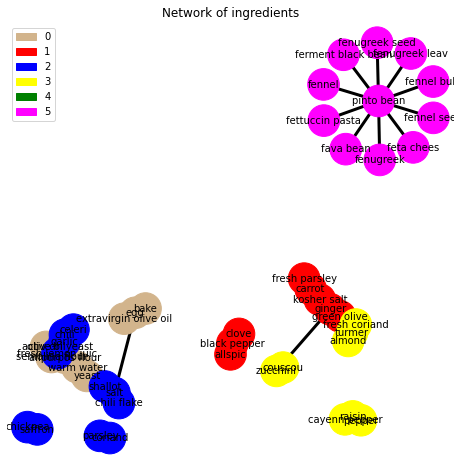

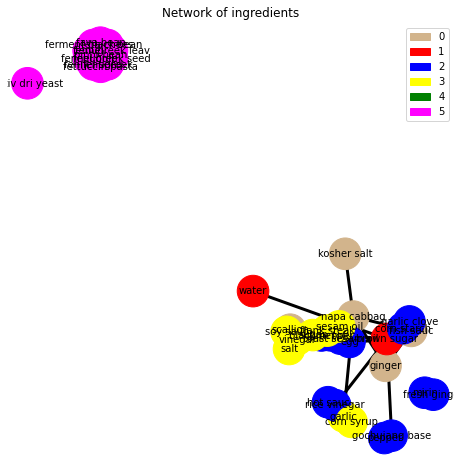

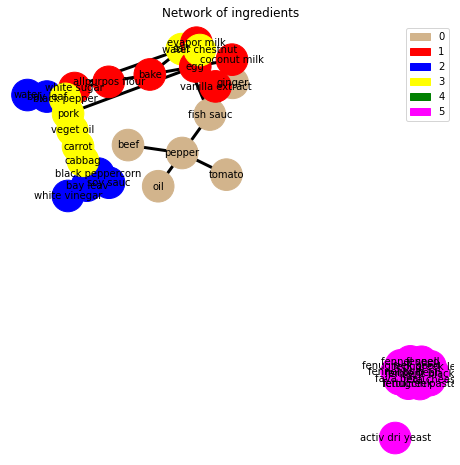

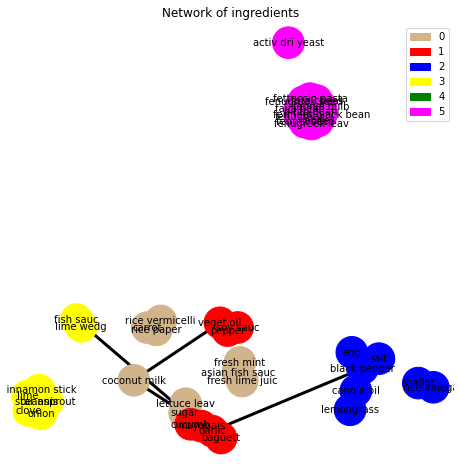

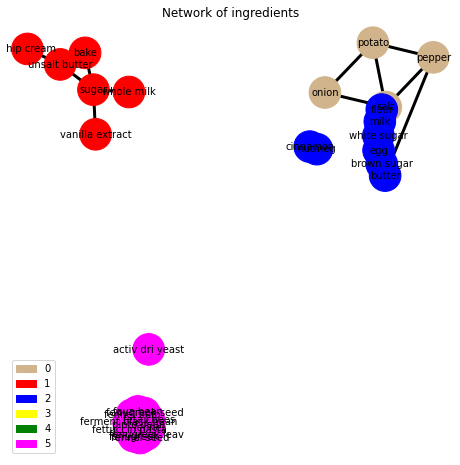

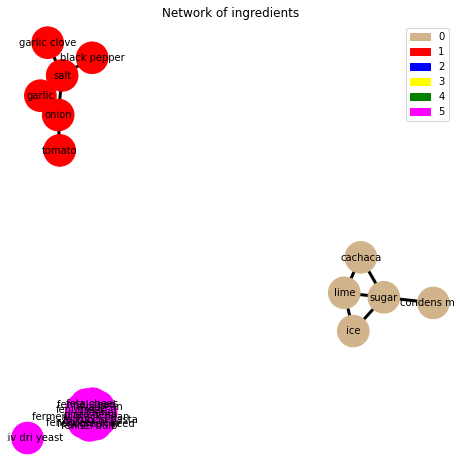

In [43]:

for cus in cuisines:
    mask = list(y_tmp.cuisine == cus)
    one_tmp_s = one_tmp[mask]
    y_tmp.loc[mask,'cluster'] = cluster_dic[cus]
    ml_utils.build_ingredient_graph(X_tmp[mask], y_tmp[mask],
                                    np.array(one_tmp_s),
                                    ft.vectorizer,
                                    palette={0:'tan',1:'red',2:'blue',3:'yellow',
                                             4:'green',5:'fuchsia'},
                                    label_col =['ID_recipe', 'cluster'],
                                    figsize=(8,8)
                                   )
    plt.show()

## Market Basket Analysis

In the following we now look at the combination of ingredients appearing together, i.e. if one uses ingredient A which other ingredients is she most likely to use. Metrics are defined as follows:
<br><br>
<img src="https://latex.codecogs.com/svg.latex?Support(A)&space;=&space;\frac{\left|A\bigcap&space;N&space;\right|}{{\left|N&space;\right|}}" title="Support(A) = \frac{\left|A\bigcap N \right|}{{\left|N \right|}}" />
<br><br>
<img src="https://latex.codecogs.com/svg.latex?Support(A&space;\Rightarrow&space;B)&space;=&space;\frac{Support(A&space;\bigcap&space;B)}{{\left|N&space;\right|}}" title="Support(A \Rightarrow B) = \frac{Support(A \bigcap B)}{{\left|N \right|}}" />
<br><br>
<img src="https://latex.codecogs.com/svg.latex?Confidence(A&space;\Rightarrow&space;B)&space;=&space;\frac{Support(A\Rightarrow&space;B)}{Support(A)}" title="Confidence(A \Rightarrow B) = \frac{Support(A\Rightarrow B)}{Support(A)}" />
<br><br>
<img src="https://latex.codecogs.com/svg.latex?Lift(A&space;\Rightarrow&space;B)&space;=&space;\frac{Support(A&space;\Rightarrow&space;B)}{Support(A)*Support(B)}" title="Lift(A \Rightarrow B) = \frac{Support(A \Rightarrow B)}{Support(A)*Support(B)}" />

In [12]:
basket = ml_utils.basket_analyzer()
basket.apriori(one_tmp)

In [13]:
basket.get_measures().sort_values(by=['lift', 'confidence'], ascending = False).iloc[0:30]

antecedents              consequents   support  confidence  \
47                (bake soda)             (buttermilk)  0.010467    0.449857   
46               (buttermilk)              (bake soda)  0.010467    0.437326   
1627           (garam masala)           (turmer, salt)  0.010133    0.418733   
1622           (turmer, salt)           (garam masala)  0.010133    0.343891   
1624     (salt, garam masala)                 (turmer)  0.010133    0.575758   
1625                 (turmer)     (salt, garam masala)  0.010133    0.238619   
495            (garam masala)                 (turmer)  0.013733    0.567493   
494                  (turmer)           (garam masala)  0.013733    0.323391   
1396         (onion, coriand)                 (turmer)  0.010267    0.557971   
1397                 (turmer)         (onion, coriand)  0.010267    0.241758   
373              (cumin seed)                 (turmer)  0.012600    0.527933   
372                  (turmer)             (cumin seed)  0.012600    0.296703   
1402          (salt, coriand)                 (turmer)  0.012067    0.514205   
1403                 (turmer)          (salt, coriand)  0.012067    0.284144   
31                (bake soda)                   (bake)  0.011933    0.512894   
30                     (bake)              (bake soda)  0.011933    0.272451   
1399                (coriand)          (turmer, onion)  0.010267    0.272566   
1394          (turmer, onion)                (coriand)  0.010267    0.436261   
1405                (coriand)           (turmer, salt)  0.012067    0.320354   
1400           (turmer, salt)                (coriand)  0.012067    0.409502   
323                 (coriand)                 (turmer)  0.016733    0.444248   
322                  (turmer)                (coriand)  0.016733    0.394035   
1904  (soy sauc, green onion)              (sesam oil)  0.012400    0.432558   
1905              (sesam oil)  (soy sauc, green onion)  0.012400    0.281818   
34               (buttermilk)                   (bake)  0.010000    0.417827   
35                     (bake)             (buttermilk)  0.010000    0.228311   
1892       (soy sauc, ginger)              (sesam oil)  0.010267    0.409574   
1893              (sesam oil)       (soy sauc, ginger)  0.010267    0.233333   
2080        (soy sauc, sugar)              (sesam oil)  0.011400    0.385135   
2081              (sesam oil)        (soy sauc, sugar)  0.011400    0.259091   

           lift  
47    18.796242  
46    18.796242  
1627  14.210389  
1622  14.210389  
1624  13.557871  
1625  13.557871  
495   13.363260  
494   13.363260  
1396  13.139035  
1397  13.139035  
373   12.431702  
372   12.431702  
1402  12.108427  
1403  12.108427  
31    11.709908  
30    11.709908  
1399  11.582140  
1394  11.582140  
1405  10.871741  
1400  10.871741  
323   10.461094  
322   10.461094  
1904   9.830867  
1905   9.830867  
34     9.539436  
35     9.539436  
1892   9.308511  
1893   9.308511  
2080   8.753071  
2081   8.753071

In [ ]:
del basket
gc.collect()
for cus in cuisines:
    print('Looking at Cuisine {}'.format(cus))
    clust = cluster_dic[cus]
    tmp = one_tmp[list(y_tmp.cuisine == cus)]
    basket = ml_utils.basket_analyzer()
    basket.apriori(tmp)
    display(pd.concat([basket.get_measures().sort_values(by=['lift'], ascending=False).iloc[0:20]],
                      axis=1, keys=[cus]))
    print('###########################################################')
    del basket
    gc.collect()

Looking at Cuisine spanish


spanish  \
                                             antecedents   
12075                            (chicken broth, shrimp)   
12062                        (olive oil, mussel, garlic)   
8731        (dri white wine, olive oil, red bell pepper)   
8738                                   (littleneck clam)   
12789                      (chicken broth, arborio rice)   
12760  (saffron thread, onion, olive oil, red bell pe...   
6583                                      (arborio rice)   
11183                                     (arborio rice)   
12805                                     (arborio rice)   
8736                   (dri white wine, red bell pepper)   
12744  (chicken broth, onion, red bell pepper, saffro...   
11154  (chicken broth, onion, olive oil, red bell pep...   
6570                (saffron thread, onion, plum tomato)   
8733                        (olive oil, littleneck clam)   
11162        (chicken broth, olive oil, red bell pepper)   
11159            (chicken broth, onion, red bell pepper)   
11175                              (onion, arborio rice)   
11178                          (olive oil, arborio rice)   
12602               (olive oil, mussel, red bell pepper)   
12751  (chicken broth, onion, olive oil, red bell pep...   

                                                                               \
                                             consequents   support confidence   
12075                        (olive oil, mussel, garlic)  0.010929   0.571429   
12062                            (chicken broth, shrimp)  0.010929   1.000000   
8731                                   (littleneck clam)  0.010929   0.800000   
8738        (dri white wine, olive oil, red bell pepper)  0.010929   0.666667   
12789  (saffron thread, onion, olive oil, red bell pe...  0.010929   0.800000   
12760                      (chicken broth, arborio rice)  0.010929   0.571429   
6583                (saffron thread, onion, plum tomato)  0.010929   0.444444   
11183  (chicken broth, onion, olive oil, red bell pep...  0.013661   0.555556   
12805  (chicken broth, onion, red bell pepper, saffro...  0.010929   0.444444   
8736                        (olive oil, littleneck clam)  0.010929   0.444444   
12744                                     (arborio rice)  0.010929   1.000000   
11154                                     (arborio rice)  0.013661   1.000000   
6570                                      (arborio rice)  0.010929   1.000000   
8733                   (dri white wine, red bell pepper)  0.010929   1.000000   
11162                              (onion, arborio rice)  0.013661   0.833333   
11159                          (olive oil, arborio rice)  0.013661   0.833333   
11175        (chicken broth, olive oil, red bell pepper)  0.013661   0.625000   
11178            (chicken broth, onion, red bell pepper)  0.013661   0.625000   
12602                           (saffron thread, shrimp)  0.010929   0.800000   
12751                     (saffron thread, arborio rice)  0.010929   0.800000   

                  
            lift  
12075  52.285714  
12062  52.285714  
8731   48.800000  
8738   48.800000  
12789  41.828571  
12760  41.828571  
6583   40.666667  
11183  40.666667  
12805  40.666667  
8736   40.666667  
12744  40.666667  
11154  40.666667  
6570   40.666667  
8733   40.666667  
11162  38.125000  
11159  38.125000  
11175  38.125000  
11178  38.125000  
12602  36.600000  
12751  36.600000

###########################################################
Looking at Cuisine mexican


mexican                                        \
                      antecedents                 consequents   support   
1389                       (bake)     (salt, allpurpos flour)  0.012632   
1384      (salt, allpurpos flour)                      (bake)  0.012632   
1385                 (salt, bake)           (allpurpos flour)  0.012632   
1388            (allpurpos flour)                (salt, bake)  0.012632   
0               (allpurpos flour)                      (bake)  0.015892   
1                          (bake)           (allpurpos flour)  0.015892   
1400            (allpurpos flour)                 (egg, salt)  0.014670   
1397                  (egg, salt)           (allpurpos flour)  0.014670   
5718   (cumin, green bell pepper)           (red bell pepper)  0.010187   
5723            (red bell pepper)  (cumin, green bell pepper)  0.010187   
15064     (salt, avocado, garlic)               (cumin, lime)  0.010595   
15069               (cumin, lime)     (salt, avocado, garlic)  0.010595   
15058         (cumin, salt, lime)           (avocado, garlic)  0.010595   
15075           (avocado, garlic)         (cumin, salt, lime)  0.010595   
14822    (cumin, avocado, garlic)           (cilantro, chili)  0.011410   
14831           (cilantro, chili)    (cumin, avocado, garlic)  0.011410   
14827           (cumin, cilantro)    (avocado, chili, garlic)  0.011410   
14826    (avocado, chili, garlic)           (cumin, cilantro)  0.011410   
14851      (cumin, salt, avocado)           (cilantro, chili)  0.011817   
14862           (cilantro, chili)      (cumin, salt, avocado)  0.011817   

                             
      confidence       lift  
1389    0.436620  13.736728  
1384    0.397436  13.736728  
1385    0.584906  11.862467  
1388    0.256198  11.862467  
0       0.322314  11.140263  
1       0.549296  11.140263  
1400    0.297521   7.850706  
1397    0.387097   7.850706  
5718    0.500000   7.668750  
5723    0.156250   7.668750  
15064   0.305882   6.886562  
15069   0.238532   6.886562  
15058   0.393939   6.856222  
15075   0.184397   6.856222  
14822   0.311111   6.816667  
14831   0.250000   6.816667  
14827   0.173913   6.774327  
14826   0.444444   6.774327  
14851   0.308511   6.759688  
14862   0.258929   6.759688

###########################################################
Looking at Cuisine french


french  \
                                 antecedents   
8                               (warm water)   
9                          (activ dri yeast)   
625                               (eggplant)   
624                               (zucchini)   
3966           (cook spray, allpurpos flour)   
3971                       (egg white, milk)   
72                          (almond extract)   
73                                  (almond)   
5980                      (salt, whole milk)   
5977        (egg, allpurpos flour, egg yolk)   
3969            (allpurpos flour, egg white)   
3968                      (cook spray, milk)   
5974                   (egg, salt, egg yolk)   
5983           (allpurpos flour, whole milk)   
85                        (anchovi raw fish)   
84                                   (caper)   
5988                         (egg, egg yolk)   
5969     (salt, allpurpos flour, whole milk)   
5991                            (whole milk)   
5966  (egg, salt, allpurpos flour, egg yolk)   

                                                                              
                                 consequents   support confidence       lift  
8                          (activ dri yeast)  0.010010   0.555556  32.647059  
9                               (warm water)  0.010010   0.588235  32.647059  
625                               (zucchini)  0.014014   0.823529  26.538899  
624                               (eggplant)  0.014014   0.451613  26.538899  
3966                       (egg white, milk)  0.010010   0.434783  19.743083  
3971           (cook spray, allpurpos flour)  0.010010   0.454545  19.743083  
72                                  (almond)  0.010010   0.526316  17.526316  
73                          (almond extract)  0.010010   0.333333  17.526316  
5980        (egg, allpurpos flour, egg yolk)  0.010010   0.277778  17.343750  
5977                      (salt, whole milk)  0.010010   0.625000  17.343750  
3969                      (cook spray, milk)  0.010010   0.400000  15.984000  
3968            (allpurpos flour, egg white)  0.010010   0.400000  15.984000  
5974           (allpurpos flour, whole milk)  0.010010   0.500000  15.136364  
5983                   (egg, salt, egg yolk)  0.010010   0.303030  15.136364  
85                                   (caper)  0.010010   0.526316  15.022556  
84                        (anchovi raw fish)  0.010010   0.285714  15.022556  
5988     (salt, allpurpos flour, whole milk)  0.010010   0.400000  14.271429  
5969                         (egg, egg yolk)  0.010010   0.357143  14.271429  
5991  (egg, salt, allpurpos flour, egg yolk)  0.010010   0.196078  12.242647  
5966                            (whole milk)  0.010010   0.625000  12.242647

###########################################################
Looking at Cuisine chinese


chinese  \
                               antecedents   
492                       (cinnamon stick)   
493                            (star anis)   
41831         (white pepper, sugar, water)   
41818          (salt, sesam oil, scallion)   
38897                  (white pepper, oil)   
38880              (salt, scallion, water)   
41632          (salt, sesam oil, scallion)   
41645        (white pepper, sugar, ginger)   
12643           (brown sugar, corn starch)   
12646            (red pepper flake, water)   
41661                (white pepper, sugar)   
41616  (salt, sesam oil, scallion, ginger)   
33531                   (oil, oyster sauc)   
33526   (white pepper, corn starch, sugar)   
41659               (white pepper, ginger)   
41618   (salt, sesam oil, scallion, sugar)   
637                         (spring onion)   
636                            (cornflour)   
33524      (oil, oyster sauc, corn starch)   
33533                (white pepper, sugar)   

                                                                            
                               consequents   support confidence       lift  
492                            (star anis)  0.014521   0.833333  22.653509  
493                       (cinnamon stick)  0.014521   0.394737  22.653509  
41831          (salt, sesam oil, scallion)  0.010649   0.458333  13.527381  
41818         (white pepper, sugar, water)  0.010649   0.314286  13.527381  
38897              (salt, scallion, water)  0.010649   0.343750  13.151620  
38880                  (white pepper, oil)  0.010649   0.407407  13.151620  
41632        (white pepper, sugar, ginger)  0.010649   0.314286  12.986286  
41645          (salt, sesam oil, scallion)  0.010649   0.440000  12.986286  
12643            (red pepper flake, water)  0.010649   0.261905  12.883220  
12646           (brown sugar, corn starch)  0.010649   0.523810  12.883220  
41661  (salt, sesam oil, scallion, ginger)  0.010649   0.171875  12.681920  
41616                (white pepper, sugar)  0.010649   0.785714  12.681920  
33531   (white pepper, corn starch, sugar)  0.010649   0.440000  12.284324  
33526                   (oil, oyster sauc)  0.010649   0.297297  12.284324  
41659   (salt, sesam oil, scallion, sugar)  0.010649   0.282051  12.139957  
41618               (white pepper, ginger)  0.010649   0.458333  12.139957  
637                            (cornflour)  0.017425   0.321429  11.858418  
636                         (spring onion)  0.017425   0.642857  11.858418  
33524                (white pepper, sugar)  0.010649   0.733333  11.836458  
33533      (oil, oyster sauc, corn starch)  0.010649   0.171875  11.836458

###########################################################
Looking at Cuisine italian


italian                                          \
                       antecedents                   consequents   support   
389                   (warm water)                   (dri yeast)  0.010441   
388                    (dri yeast)                  (warm water)  0.010441   
3                (activ dri yeast)                  (warm water)  0.011115   
2                     (warm water)             (activ dri yeast)  0.011115   
55               (vanilla extract)                        (bake)  0.010778   
54                          (bake)             (vanilla extract)  0.010778   
3287                  (salt, bake)        (egg, allpurpos flour)  0.010441   
3290        (egg, allpurpos flour)                  (salt, bake)  0.010441   
1071                  (egg, sugar)                        (bake)  0.010104   
1074                        (bake)                  (egg, sugar)  0.010104   
933                         (bake)        (egg, allpurpos flour)  0.017178   
928         (egg, allpurpos flour)                        (bake)  0.017178   
3283  (egg, salt, allpurpos flour)                        (bake)  0.010441   
3294                        (bake)  (egg, salt, allpurpos flour)  0.010441   
1052      (butter, dri white wine)                (arborio rice)  0.011452   
1057                (arborio rice)      (butter, dri white wine)  0.011452   
222                       (carrot)                  (celeri rib)  0.013473   
223                   (celeri rib)                      (carrot)  0.013473   
1742                (salt, celeri)                      (carrot)  0.012125   
1743                      (carrot)                (salt, celeri)  0.012125   

                            
     confidence       lift  
389    0.413333  34.088519  
388    0.861111  34.088519  
3      0.767442  30.380465  
2      0.440000  30.380465  
55     0.376471  17.196018  
54     0.492308  17.196018  
3287   0.815789  16.589582  
3290   0.212329  16.589582  
1071   0.357143  16.313187  
1074   0.461538  16.313187  
933    0.784615  15.955638  
928    0.349315  15.955638  
3283   0.344444  15.733162  
3294   0.476923  15.733162  
1052   0.459459  13.506288  
1057   0.336634  13.506288  
222    0.238095  12.623299  
223    0.714286  12.623299  
1742   0.642857  11.360969  
1743   0.214286  11.360969

###########################################################
Looking at Cuisine southern_us


southern_us  \
                                         antecedents   
642                                        (ketchup)   
643                             (worcestershir sauc)   
2765                        (cinnamon, sweet potato)   
2768                                        (nutmeg)   
9321             (yellow corn meal, salt, bake soda)   
9336                         (egg, buttermilk, bake)   
9342                   (yellow corn meal, bake soda)   
9315                   (egg, salt, buttermilk, bake)   
8253                   (yellow corn meal, bake soda)   
8248                         (egg, buttermilk, bake)   
9337                          (egg, bake, bake soda)   
9320            (yellow corn meal, salt, buttermilk)   
3268                                  (salt, nutmeg)   
3273                                  (sweet potato)   
9341                  (yellow corn meal, buttermilk)   
9316                    (egg, salt, bake, bake soda)   
9324              (egg, yellow corn meal, bake soda)   
9333                        (salt, buttermilk, bake)   
6712  (yellow corn meal, allpurpos flour, bake soda)   
6729                              (buttermilk, bake)   

                                                                           \
                                         consequents   support confidence   
642                             (worcestershir sauc)  0.011736   0.655172   
643                                        (ketchup)  0.011736   0.271429   
2765                                        (nutmeg)  0.010500   0.566667   
2768                        (cinnamon, sweet potato)  0.010500   0.261538   
9321                         (egg, buttermilk, bake)  0.010500   0.607143   
9336             (yellow corn meal, salt, bake soda)  0.010500   0.242857   
9342                   (egg, salt, buttermilk, bake)  0.010500   0.472222   
9315                   (yellow corn meal, bake soda)  0.010500   0.309091   
8253                         (egg, buttermilk, bake)  0.012353   0.555556   
8248                   (yellow corn meal, bake soda)  0.012353   0.285714   
9337            (yellow corn meal, salt, buttermilk)  0.010500   0.261538   
9320                          (egg, bake, bake soda)  0.010500   0.485714   
3268                                  (sweet potato)  0.011118   0.450000   
3273                                  (salt, nutmeg)  0.011118   0.285714   
9341                    (egg, salt, bake, bake soda)  0.010500   0.361702   
9316                  (yellow corn meal, buttermilk)  0.010500   0.326923   
9324                        (salt, buttermilk, bake)  0.010500   0.586207   
9333              (egg, yellow corn meal, bake soda)  0.010500   0.200000   
6712                              (buttermilk, bake)  0.010500   0.772727   
6729  (yellow corn meal, allpurpos flour, bake soda)  0.010500   0.147826   

                 
           lift  
642   15.153202  
643   15.153202  
2765  14.114359  
2768  14.114359  
9321  14.042347  
9336  14.042347  
9342  13.900505  
9315  13.900505  
8253  12.849206  
8248  12.849206  
9337  12.098022  
9320  12.098022  
3268  11.564286  
3273  11.564286  
9341  11.261457  
9316  11.261457  
9324  11.165517  
9333  11.165517  
6712  10.878656  
6729  10.878656

###########################################################
Looking at Cuisine indian


indian                                   \
                            antecedents                      consequents   
8974                   (green cardamom)             (clove, garlic past)   
8971               (clove, garlic past)                 (green cardamom)   
9084                       (clove, oil)                 (green cardamom)   
9089                   (green cardamom)                     (clove, oil)   
34363                  (green cardamom)       (clove, salt, green chili)   
34350        (clove, salt, green chili)                 (green cardamom)   
34340              (clove, green chili)          (green cardamom, onion)   
34345           (green cardamom, onion)             (clove, green chili)   
34348                  (green cardamom)      (clove, green chili, onion)   
34337       (clove, green chili, onion)                 (green cardamom)   
27402   (cinnamon stick, cilantro leav)             (clove, green chili)   
27403              (clove, green chili)  (cinnamon stick, cilantro leav)   
113312      (salt, onion, coriand seed)      (turmer, clove, cumin seed)   
113329      (turmer, clove, cumin seed)      (salt, onion, coriand seed)   
9078               (clove, green chili)                 (green cardamom)   
9083                   (green cardamom)             (clove, green chili)   
73609        (salt, clove, garlic past)         (tomato, cinnamon stick)   
73616          (tomato, cinnamon stick)       (salt, clove, garlic past)   
31906          (tomato, cinnamon stick)             (clove, garlic past)   
31911              (clove, garlic past)         (tomato, cinnamon stick)   

                                        
         support confidence       lift  
8974    0.012635   0.500000  17.312500  
8971    0.012635   0.437500  17.312500  
9084    0.010830   0.400000  15.828571  
9089    0.010830   0.428571  15.828571  
34363   0.010830   0.428571  15.317972  
34350   0.010830   0.387097  15.317972  
34340   0.010830   0.285714  15.074830  
34345   0.010830   0.571429  15.074830  
34348   0.010830   0.428571  14.839286  
34337   0.010830   0.375000  14.839286  
27402   0.010830   0.545455  14.389610  
27403   0.010830   0.285714  14.389610  
113312  0.010830   0.413793  14.327586  
113329  0.010830   0.375000  14.327586  
9078    0.013538   0.357143  14.132653  
9083    0.013538   0.535714  14.132653  
73609   0.010830   0.444444  14.069841  
73616   0.010830   0.342857  14.069841  
31906   0.012635   0.400000  13.850000  
31911   0.012635   0.437500  13.850000

###########################################################
Looking at Cuisine thai


thai  \
                                   antecedents   
10593          (rice noodl, fish sauc, garlic)   
10608                            (egg, peanut)   
10533          (rice noodl, fish sauc, garlic)   
10548                     (peanut, beansprout)   
10578                 (sesam oil, green onion)   
10563       (cilantro, rice vinegar, soy sauc)   
10661            (peanut butter, rice vinegar)   
10660       (sesam oil, soy sauc, green onion)   
10577                 (rice vinegar, soy sauc)   
10564       (cilantro, sesam oil, green onion)   
10518                            (egg, peanut)   
10503         (rice noodl, beansprout, garlic)   
10653  (peanut butter, rice vinegar, soy sauc)   
10668                 (sesam oil, green onion)   
10568    (rice vinegar, soy sauc, green onion)   
10573                    (cilantro, sesam oil)   
8563                      (rice noodl, shrimp)   
8562                         (egg, beansprout)   
10570       (sesam oil, soy sauc, green onion)   
10571                 (cilantro, rice vinegar)   

                                                                                
                                   consequents   support confidence       lift  
10593                            (egg, peanut)  0.011513   0.777778  23.644444  
10608          (rice noodl, fish sauc, garlic)  0.011513   0.350000  23.644444  
10533                     (peanut, beansprout)  0.011513   0.777778  19.703704  
10548          (rice noodl, fish sauc, garlic)  0.011513   0.291667  19.703704  
10578       (cilantro, rice vinegar, soy sauc)  0.011513   0.291667  17.733333  
10563                 (sesam oil, green onion)  0.011513   0.700000  17.733333  
10661       (sesam oil, soy sauc, green onion)  0.011513   0.500000  16.888889  
10660            (peanut butter, rice vinegar)  0.011513   0.388889  16.888889  
10577       (cilantro, sesam oil, green onion)  0.011513   0.218750  16.625000  
10564                 (rice vinegar, soy sauc)  0.011513   0.875000  16.625000  
10518         (rice noodl, beansprout, garlic)  0.013158   0.400000  16.213333  
10503                            (egg, peanut)  0.013158   0.533333  16.213333  
10653                 (sesam oil, green onion)  0.011513   0.636364  16.121212  
10668  (peanut butter, rice vinegar, soy sauc)  0.011513   0.291667  16.121212  
10568                    (cilantro, sesam oil)  0.011513   0.368421  16.000000  
10573    (rice vinegar, soy sauc, green onion)  0.011513   0.500000  16.000000  
8563                         (egg, beansprout)  0.016447   0.833333  15.833333  
8562                      (rice noodl, shrimp)  0.016447   0.312500  15.833333  
10570                 (cilantro, rice vinegar)  0.011513   0.388889  15.762963  
10571       (sesam oil, soy sauc, green onion)  0.011513   0.466667  15.762963

###########################################################
Looking at Cuisine cajun_creole


cajun_creole  \
                                         antecedents   
24430                        (salt, activ dri yeast)   
24431                              (egg, warm water)   
24437                              (activ dri yeast)   
24424                        (egg, salt, warm water)   
2672                               (egg, warm water)   
2677                               (activ dri yeast)   
24445                            (warm water, sugar)   
24348                        (activ dri yeast, milk)   
24345                                (cinnamon, egg)   
24444                        (salt, activ dri yeast)   
2703                         (salt, activ dri yeast)   
2706                                    (warm water)   
24426                   (egg, salt, activ dri yeast)   
24435                                   (warm water)   
24449                                   (warm water)   
24440                 (salt, activ dri yeast, sugar)   
128452  (file, allpurpos flour, black pepper, onion)   
128521      (bay leav, green bell pepper, veget oil)   
2613                          (egg, activ dri yeast)   
2616                                   (bread flour)   

                                                                           \
                                         consequents   support confidence   
24430                              (egg, warm water)  0.015228   0.692308   
24431                        (salt, activ dri yeast)  0.015228   1.000000   
24437                        (egg, salt, warm water)  0.015228   0.600000   
24424                              (activ dri yeast)  0.015228   1.000000   
2672                               (activ dri yeast)  0.015228   1.000000   
2677                               (egg, warm water)  0.015228   0.600000   
24445                        (salt, activ dri yeast)  0.010152   0.857143   
24348                                (cinnamon, egg)  0.010152   0.857143   
24345                        (activ dri yeast, milk)  0.010152   0.461538   
24444                            (warm water, sugar)  0.010152   0.461538   
2703                                    (warm water)  0.016920   0.769231   
2706                         (salt, activ dri yeast)  0.016920   0.833333   
24426                                   (warm water)  0.015228   0.750000   
24435                   (egg, salt, activ dri yeast)  0.015228   0.750000   
24449                 (salt, activ dri yeast, sugar)  0.010152   0.500000   
24440                                   (warm water)  0.010152   0.750000   
128452      (bay leav, green bell pepper, veget oil)  0.010152   0.857143   
128521  (file, allpurpos flour, black pepper, onion)  0.010152   0.428571   
2613                                   (bread flour)  0.010152   0.428571   
2616                          (egg, activ dri yeast)  0.010152   0.857143   

                   
             lift  
24430   45.461538  
24431   45.461538  
24437   39.400000  
24424   39.400000  
2672    39.400000  
2677    39.400000  
24445   38.967033  
24348   38.967033  
24345   38.967033  
24444   38.967033  
2703    37.884615  
2706    37.884615  
24426   36.937500  
24435   36.937500  
24449   36.937500  
24440   36.937500  
128452  36.183673  
128521  36.183673  
2613    36.183673  
2616    36.183673

###########################################################
Looking at Cuisine jamaican


jamaican  \
                                        antecedents   
416157               (scallion, black bean, garlic)   
339394           (allspic, salt, clove, black bean)   
339407              (allspic, rum, clove, scallion)   
339405           (rum, clove, scallion, black bean)   
339404       (allspic, clove, scallion, black bean)   
339403         (allspic, salt, longgrain rice, rum)   
339401  (allspic, salt, longgrain rice, black bean)   
339400             (allspic, salt, black bean, rum)   
339399           (longgrain rice, salt, clove, rum)   
339398       (allspic, salt, clove, longgrain rice)   
339397                  (allspic, salt, clove, rum)   
339395               (salt, clove, black bean, rum)   
339413     (allspic, rum, longgrain rice, scallion)   
339326         (nutmeg, longgrain rice, black bean)   
339414            (allspic, rum, clove, black bean)   
339429                      (salt, black bean, rum)   
339438              (allspic, scallion, black bean)   
339437            (longgrain rice, clove, scallion)   
339436                       (rum, clove, scallion)   
339434                (clove, scallion, black bean)   

                                                                                
                                        consequents   support confidence  lift  
416157    (longgrain rice, salt, black pepper, rum)  0.013889        1.0  72.0  
339394              (rum, longgrain rice, scallion)  0.013889        1.0  72.0  
339407           (salt, longgrain rice, black bean)  0.013889        1.0  72.0  
339405              (allspic, salt, longgrain rice)  0.013889        1.0  72.0  
339404                  (salt, longgrain rice, rum)  0.013889        1.0  72.0  
339403                (clove, scallion, black bean)  0.013889        1.0  72.0  
339401                       (rum, clove, scallion)  0.013889        1.0  72.0  
339400            (longgrain rice, clove, scallion)  0.013889        1.0  72.0  
339399              (allspic, scallion, black bean)  0.013889        1.0  72.0  
339398                  (rum, scallion, black bean)  0.013889        1.0  72.0  
339397       (longgrain rice, scallion, black bean)  0.013889        1.0  72.0  
339395          (allspic, longgrain rice, scallion)  0.013889        1.0  72.0  
339413                    (salt, clove, black bean)  0.013889        1.0  72.0  
339326             (allspic, salt, clove, scallion)  0.013889        1.0  72.0  
339414             (salt, longgrain rice, scallion)  0.013889        1.0  72.0  
339429   (allspic, clove, scallion, longgrain rice)  0.013889        1.0  72.0  
339438           (longgrain rice, salt, clove, rum)  0.013889        1.0  72.0  
339437             (allspic, salt, black bean, rum)  0.013889        1.0  72.0  
339436  (allspic, salt, longgrain rice, black bean)  0.013889        1.0  72.0  
339434         (allspic, salt, longgrain rice, rum)  0.013889        1.0  72.0

###########################################################
Looking at Cuisine japanese


japanese                                        \
                     antecedents                 consequents   support   
4214            (turmer, butter)       (garam masala, sugar)  0.011321   
4219       (garam masala, sugar)            (turmer, butter)  0.011321   
4216             (turmer, sugar)      (butter, garam masala)  0.011321   
4217      (butter, garam masala)             (turmer, sugar)  0.011321   
4205       (onion, garam masala)            (turmer, butter)  0.011321   
4200            (turmer, butter)       (onion, garam masala)  0.011321   
4511            (onion, coriand)               (tomato, oil)  0.011321   
4506               (tomato, oil)            (onion, coriand)  0.011321   
6481                   (coriand)  (turmer, salt, oil, onion)  0.013208   
6456  (turmer, salt, oil, onion)                   (coriand)  0.013208   
4211     (turmer, butter, sugar)              (garam masala)  0.011321   
4209              (garam masala)     (turmer, butter, onion)  0.011321   
4196     (turmer, butter, onion)              (garam masala)  0.011321   
4222              (garam masala)     (turmer, butter, sugar)  0.011321   
34                        (bake)           (vanilla extract)  0.011321   
4325        (salt, garam masala)            (chili, coriand)  0.011321   
35             (vanilla extract)                      (bake)  0.011321   
4328            (chili, coriand)        (salt, garam masala)  0.011321   
4516        (turmer, oil, onion)                   (coriand)  0.015094   
4529                   (coriand)        (turmer, oil, onion)  0.015094   

                            
     confidence       lift  
4214   0.750000  66.250000  
4219   1.000000  66.250000  
4216   0.666667  44.166667  
4217   0.750000  44.166667  
4205   0.545455  36.136364  
4200   0.750000  36.136364  
4511   0.600000  31.800000  
4506   0.600000  31.800000  
6481   0.466667  30.916667  
6456   0.875000  30.916667  
4211   1.000000  29.444444  
4209   0.333333  29.444444  
4196   1.000000  29.444444  
4222   0.333333  29.444444  
34     0.428571  28.392857  
4325   0.428571  28.392857  
35     0.750000  28.392857  
4328   0.750000  28.392857  
4516   0.800000  28.266667  
4529   0.533333  28.266667

###########################################################
Looking at Cuisine greek


greek  \
                                           antecedents   
26264             (onion, olive oil, feta chees, milk)   
26166                      (allpurpos flour, eggplant)   
26228                                  (egg, eggplant)   
26285                      (allpurpos flour, eggplant)   
26197        (allpurpos flour, onion, olive oil, milk)   
26135                 (butter, onion, olive oil, milk)   
20692                              (nutmeg, olive oil)   
20677                         (butter, eggplant, milk)   
19523                                 (eggplant, milk)   
26279                      (eggplant, olive oil, milk)   
26172                                 (eggplant, milk)   
19510             (allpurpos flour, onion, feta chees)   
20678                      (butter, nutmeg, olive oil)   
20691                                 (eggplant, milk)   
26293                                 (eggplant, milk)   
26270             (allpurpos flour, onion, feta chees)   
26129      (butter, allpurpos flour, onion, olive oil)   
26256  (allpurpos flour, onion, olive oil, feta chees)   
20690                               (nutmeg, eggplant)   
19401                                  (egg, eggplant)   

                                                                             \
                                           consequents   support confidence   
26264                      (allpurpos flour, eggplant)  0.010941   0.833333   
26166                 (butter, onion, olive oil, milk)  0.010941   0.625000   
26228        (allpurpos flour, onion, olive oil, milk)  0.010941   0.833333   
26285             (onion, olive oil, feta chees, milk)  0.010941   0.625000   
26197                                  (egg, eggplant)  0.010941   0.625000   
26135                      (allpurpos flour, eggplant)  0.010941   0.833333   
20692                         (butter, eggplant, milk)  0.010941   0.714286   
20677                              (nutmeg, olive oil)  0.010941   0.714286   
19523             (allpurpos flour, onion, feta chees)  0.010941   0.500000   
26279             (allpurpos flour, onion, feta chees)  0.010941   0.500000   
26172      (butter, allpurpos flour, onion, olive oil)  0.010941   0.500000   
19510                                 (eggplant, milk)  0.010941   1.000000   
20678                                 (eggplant, milk)  0.010941   1.000000   
20691                      (butter, nutmeg, olive oil)  0.010941   0.500000   
26293  (allpurpos flour, onion, olive oil, feta chees)  0.010941   0.500000   
26270                      (eggplant, olive oil, milk)  0.010941   1.000000   
26129                                 (eggplant, milk)  0.010941   1.000000   
26256                                 (eggplant, milk)  0.010941   1.000000   
20690                        (butter, olive oil, milk)  0.010941   0.833333   
19401                   (allpurpos flour, onion, milk)  0.010941   0.833333   

                  
            lift  
26264  47.604167  
26166  47.604167  
26228  47.604167  
26285  47.604167  
26197  47.604167  
26135  47.604167  
20692  46.632653  
20677  46.632653  
19523  45.700000  
26279  45.700000  
26172  45.700000  
19510  45.700000  
20678  45.700000  
20691  45.700000  
26293  45.700000  
26270  45.700000  
26129  45.700000  
26256  45.700000  
20690  42.314815  
19401  42.314815

###########################################################
Looking at Cuisine russian


russian  \
                                              antecedents   
148191                             (broth, carrot, water)   
143557           (unsalt butter, honey, confection sugar)   
143573                           (allpurpos flour, honey)   
143568                                      (salt, honey)   
143563                   (cinnamon, unsalt butter, honey)   
143561                   (cinnamon, unsalt butter, water)   
143560                      (unsalt butter, honey, water)   
143558        (cinnamon, unsalt butter, confection sugar)   
143556                (cinnamon, water, confection sugar)   
143577                          (honey, confection sugar)   
168828                       (broth, cabbag, onion, beet)   
168829                      (broth, cabbag, potato, beet)   
168832                       (broth, potato, onion, beet)   
168823                    (broth, cabbag, carrot, potato)   
143554           (water, unsalt butter, confection sugar)   
143553                 (cinnamon, allpurpos flour, honey)   
143575                          (water, confection sugar)   
143578                       (cinnamon, confection sugar)   
143497  (cinnamon, salt, allpurpos flour, confection s...   
143305                        (egg, unsalt butter, honey)   

                                                                     \
                                              consequents   support   
148191                        (cabbag, dill, onion, beet)  0.011834   
143557           (cinnamon, salt, allpurpos flour, water)  0.011834   
143573  (salt, water, confection sugar, unsalt butter,...  0.011834   
143568  (allpurpos flour, water, confection sugar, uns...  0.011834   
143563   (water, salt, allpurpos flour, confection sugar)  0.011834   
143561   (salt, allpurpos flour, honey, confection sugar)  0.011834   
143560  (cinnamon, salt, allpurpos flour, confection s...  0.011834   
143558              (salt, allpurpos flour, honey, water)  0.011834   
143556      (salt, allpurpos flour, unsalt butter, honey)  0.011834   
143577  (salt, allpurpos flour, water, unsalt butter, ...  0.011834   
168828                      (carrot, potato, dill, water)  0.011834   
168829                       (carrot, dill, onion, water)  0.011834   
168832                      (carrot, cabbag, dill, water)  0.011834   
168823                         (dill, onion, beet, water)  0.011834   
143554           (cinnamon, salt, allpurpos flour, honey)  0.011834   
143553     (water, salt, unsalt butter, confection sugar)  0.011834   
143575  (salt, allpurpos flour, unsalt butter, honey, ...  0.011834   
143578  (salt, allpurpos flour, water, unsalt butter, ...  0.011834   
143497                      (unsalt butter, honey, water)  0.011834   
143305  (cinnamon, water, allpurpos flour, confection ...  0.011834   

                         
       confidence  lift  
148191        1.0  84.5  
143557        1.0  84.5  
143573        1.0  84.5  
143568        1.0  84.5  
143563        1.0  84.5  
143561        1.0  84.5  
143560        1.0  84.5  
143558        1.0  84.5  
143556        1.0  84.5  
143577        1.0  84.5  
168828        1.0  84.5  
168829        1.0  84.5  
168832        1.0  84.5  
168823        1.0  84.5  
143554        1.0  84.5  
143553        1.0  84.5  
143575        1.0  84.5  
143578        1.0  84.5  
143497        1.0  84.5  
143305        1.0  84.5

###########################################################
Looking at Cuisine irish


irish  \
                                 antecedents   
19123              (molass, allpurpos flour)   
19106                 (butter, salt, ginger)   
24893                 (potato, onion, thyme)   
26182                  (potato, salt, thyme)   
13344                               (molass)   
25073                  (potato, salt, thyme)   
24871        (potato, onion, pepper, garlic)   
25098                        (potato, thyme)   
26198                 (potato, onion, thyme)   
26145         (potato, salt, pepper, garlic)   
26120  (salt, garlic, onion, potato, pepper)   
19129                               (molass)   
26148           (potato, salt, onion, thyme)   
24912                        (potato, thyme)   
26161        (potato, onion, pepper, garlic)   
25057         (potato, salt, pepper, garlic)   
19479                        (potato, thyme)   
26223                        (potato, thyme)   
25100                         (bacon, thyme)   
24892                (pepper, bacon, garlic)   

                                                                           
                                   consequents   support confidence  lift  
19123                   (butter, salt, ginger)  0.012195       1.00  82.0  
19106                (molass, allpurpos flour)  0.012195       1.00  82.0  
24893                  (pepper, bacon, garlic)  0.012195       0.75  61.5  
26182           (pepper, onion, bacon, garlic)  0.012195       0.75  61.5  
13344                   (butter, salt, ginger)  0.012195       0.75  61.5  
25073                  (pepper, bacon, garlic)  0.012195       0.75  61.5  
24871                           (bacon, thyme)  0.012195       0.75  61.5  
25098            (salt, pepper, bacon, garlic)  0.012195       0.75  61.5  
26198            (salt, pepper, bacon, garlic)  0.012195       0.75  61.5  
26145                    (onion, bacon, thyme)  0.012195       0.75  61.5  
26120                           (bacon, thyme)  0.012195       0.75  61.5  
19129  (butter, salt, allpurpos flour, ginger)  0.012195       0.75  61.5  
26148                  (pepper, bacon, garlic)  0.012195       0.75  61.5  
24912           (pepper, onion, bacon, garlic)  0.012195       0.75  61.5  
26161                     (salt, bacon, thyme)  0.012195       0.75  61.5  
25057                           (bacon, thyme)  0.012195       0.75  61.5  
19479                  (pepper, bacon, garlic)  0.012195       0.75  61.5  
26223     (salt, garlic, onion, pepper, bacon)  0.012195       0.75  61.5  
25100           (potato, salt, pepper, garlic)  0.012195       1.00  61.5  
24892                   (potato, onion, thyme)  0.012195       1.00  61.5

###########################################################
Looking at Cuisine moroccan


moroccan  \
                                            antecedents   
323035                         (turnip, salt, zucchini)   
340417                   (garlic, yellow onion, ginger)   
340384  (kosher salt, cumin, saffron thread, olive oil)   
313154                    (turmer, salt, almond, onion)   
313155                 (salt, almond, onion, olive oil)   
313097                        (cinnamon, pepper, prune)   
313212                      (pepper, almond, olive oil)   
344104                 (cumin, garlic, couscou, ginger)   
313199                            (turmer, salt, prune)   
313201                         (salt, olive oil, prune)   
313215                           (turmer, onion, prune)   
313222                          (turmer, pepper, prune)   
340133       (cumin, paprika, preserv lemon, olive oil)   
233312                       (pepper, olive oil, prune)   
112881                                   (yeast, honey)   
233307                      (pepper, almond, olive oil)   
233305                         (turmer, almond, pepper)   
233300                         (salt, olive oil, prune)   
233298                            (turmer, salt, prune)   
233293                           (turmer, salt, almond)   

                                                                              \
                                            consequents   support confidence   
323035           (chickpea, carrot, olive oil, couscou)  0.010204        1.0   
340417  (kosher salt, cumin, saffron thread, olive oil)  0.010204        1.0   
340384                   (garlic, yellow onion, ginger)  0.010204        1.0   
313154                       (pepper, olive oil, prune)  0.010204        1.0   
313155                          (turmer, pepper, prune)  0.010204        1.0   
313097                     (cumin, salt, almond, onion)  0.010204        1.0   
313212                     (turmer, salt, onion, prune)  0.010204        1.0   
344104    (cinnamon, paprika, preserv lemon, olive oil)  0.010204        1.0   
313199               (pepper, almond, onion, olive oil)  0.010204        1.0   
313201                  (turmer, almond, onion, pepper)  0.010204        1.0   
313215                (pepper, salt, almond, olive oil)  0.010204        1.0   
313222                 (salt, almond, onion, olive oil)  0.010204        1.0   
340133                        (garlic, couscou, ginger)  0.010204        1.0   
233312                           (turmer, salt, almond)  0.010204        1.0   
112881                           (warm water, semolina)  0.010204        1.0   
233307                            (turmer, salt, prune)  0.010204        1.0   
233305                         (salt, olive oil, prune)  0.010204        1.0   
233300                         (turmer, almond, pepper)  0.010204        1.0   
233298                      (pepper, almond, olive oil)  0.010204        1.0   
233293                       (pepper, olive oil, prune)  0.010204        1.0   

              
        lift  
323035  98.0  
340417  98.0  
340384  98.0  
313154  98.0  
313155  98.0  
313097  98.0  
313212  98.0  
344104  98.0  
313199  98.0  
313201  98.0  
313215  98.0  
313222  98.0  
340133  98.0  
233312  98.0  
112881  98.0  
233307  98.0  
233305  98.0  
233300  98.0  
233298  98.0  
233293  98.0

###########################################################
Looking at Cuisine korean


korean                                      \
                              antecedents                         consequents   
4387                   (dark brown sugar)               (short rib, soy sauc)   
4386                (short rib, soy sauc)                  (dark brown sugar)   
4388                          (short rib)        (dark brown sugar, soy sauc)   
440                    (dark brown sugar)                         (short rib)   
4385         (dark brown sugar, soy sauc)                         (short rib)   
441                           (short rib)                  (dark brown sugar)   
35176  (soy sauc, gochujang base, cucumb)              (kimchi, rice vinegar)   
35185              (kimchi, rice vinegar)  (soy sauc, gochujang base, cucumb)   
27307             (scallion, napa cabbag)               (kosher salt, shrimp)   
27302               (kosher salt, shrimp)             (scallion, napa cabbag)   
46258  (sesam oil, soy sauc, corn starch)      (garlic, rice vinegar, ginger)   
46239      (garlic, rice vinegar, ginger)  (sesam oil, soy sauc, corn starch)   
17052            (gochujang base, cucumb)              (kimchi, rice vinegar)   
17049              (kimchi, rice vinegar)            (gochujang base, cucumb)   
47968       (rice wine, sesam oil, onion)            (soy sauc, honey, sugar)   
47977            (soy sauc, honey, sugar)       (rice wine, sesam oil, onion)   
46254     (soy sauc, corn starch, garlic)   (sesam oil, rice vinegar, ginger)   
35178    (kimchi, rice vinegar, soy sauc)            (gochujang base, cucumb)   
46243   (sesam oil, rice vinegar, ginger)     (soy sauc, corn starch, garlic)   
35183            (gochujang base, cucumb)    (kimchi, rice vinegar, soy sauc)   

                                       
        support confidence       lift  
4387   0.013158   0.800000  60.800000  
4386   0.013158   1.000000  60.800000  
4388   0.013158   0.800000  48.640000  
440    0.013158   0.800000  48.640000  
4385   0.013158   0.800000  48.640000  
441    0.013158   0.800000  48.640000  
35176  0.013158   0.800000  40.533333  
35185  0.013158   0.666667  40.533333  
27307  0.013158   0.500000  38.000000  
27302  0.013158   1.000000  38.000000  
46258  0.013158   0.800000  34.742857  
46239  0.013158   0.571429  34.742857  
17052  0.013158   0.666667  33.777778  
17049  0.013158   0.666667  33.777778  
47968  0.013158   0.444444  33.777778  
47977  0.013158   1.000000  33.777778  
46254  0.013158   0.666667  33.777778  
35178  0.013158   0.666667  33.777778  
46243  0.013158   0.666667  33.777778  
35183  0.013158   0.666667  33.777778

###########################################################
Looking at Cuisine filipino


filipino  \
                                             antecedents   
93289                       (carrot, oil, onion, potato)   
96191               (oil, garlic, carrot, onion, potato)   
96389                              (carrot, oil, potato)   
95111          (pepper, onion, green bell pepper, water)   
93320         (garlic, pepper, green bell pepper, water)   
84664         (garlic, pepper, green bell pepper, water)   
95020    (salt, water, onion, pepper, green bell pepper)   
96151   (salt, garlic, water, pepper, green bell pepper)   
88429                  (salt, shrimp past, onion, water)   
93286                      (carrot, potato, oil, garlic)   
95093                       (carrot, oil, onion, potato)   
95054                        (carrot, salt, oil, potato)   
84646                      (carrot, potato, oil, garlic)   
93375                 (pepper, green bell pepper, water)   
84695                 (pepper, green bell pepper, water)   
96218  (garlic, water, onion, pepper, green bell pepper)   
95145                              (carrot, oil, potato)   
94056           (salt, pepper, green bell pepper, water)   
95072           (salt, pepper, green bell pepper, water)   
96299                      (carrot, potato, oil, garlic)   

                                                                               \
                                             consequents   support confidence   
93289         (garlic, pepper, green bell pepper, water)  0.010381        1.0   
96191           (salt, pepper, green bell pepper, water)  0.010381        1.0   
96389  (salt, garlic, water, onion, pepper, green bel...  0.010381        1.0   
95111                        (carrot, salt, oil, potato)  0.010381        1.0   
93320                       (carrot, oil, onion, potato)  0.010381        1.0   
84664                              (carrot, oil, potato)  0.010381        1.0   
95020                              (carrot, oil, potato)  0.010381        1.0   
96151                       (carrot, oil, onion, potato)  0.010381        1.0   
88429                         (eggplant, pepper, garlic)  0.010381        1.0   
93286          (pepper, onion, green bell pepper, water)  0.010381        1.0   
95093           (salt, pepper, green bell pepper, water)  0.010381        1.0   
95054          (pepper, onion, green bell pepper, water)  0.010381        1.0   
84646                 (pepper, green bell pepper, water)  0.010381        1.0   
93375               (oil, garlic, carrot, onion, potato)  0.010381        1.0   
84695                      (carrot, potato, oil, garlic)  0.010381        1.0   
96218                        (carrot, salt, oil, potato)  0.010381        1.0   
95145    (salt, water, onion, pepper, green bell pepper)  0.010381        1.0   
94056                      (carrot, potato, oil, garlic)  0.010381        1.0   
95072                       (carrot, oil, onion, potato)  0.010381        1.0   
96299    (salt, water, onion, pepper, green bell pepper)  0.010381        1.0   

                  
            lift  
93289  96.333333  
96191  96.333333  
96389  96.333333  
95111  96.333333  
93320  96.333333  
84664  96.333333  
95020  96.333333  
96151  96.333333  
88429  96.333333  
93286  96.333333  
95093  96.333333  
95054  96.333333  
84646  96.333333  
93375  96.333333  
84695  96.333333  
96218  96.333333  
95145  96.333333  
94056  96.333333  
95072  96.333333  
96299  96.333333

###########################################################
Looking at Cuisine vietnamese


vietnamese  \
                                     antecedents   
23826                      (onion, coconut milk)   
25476                      (onion, coconut milk)   
27456  (carrot, veget oil, coconut milk, garlic)   
25467          (veget oil, coconut milk, garlic)   
27401     (beansprout, peel fresh ginger, water)   
25465              (onion, coconut milk, garlic)   
14986                     (carrot, coconut milk)   
27465                 (carrot, curri, veget oil)   
27467                  (curri, onion, veget oil)   
23750                     (curri, onion, garlic)   
23822                         (curri, veget oil)   
23796                     (carrot, coconut milk)   
23824                     (carrot, coconut milk)   
23811                 (carrot, curri, veget oil)   
27455         (carrot, veget oil, onion, garlic)   
27460                     (curri, onion, garlic)   
27446         (carrot, veget oil, curri, garlic)   
27454      (carrot, onion, coconut milk, garlic)   
25472                         (curri, veget oil)   
23882                         (curri, veget oil)   

                                                                      
                             consequents   support confidence   lift  
23826         (carrot, curri, veget oil)  0.013029        1.0  76.75  
25476         (veget oil, curri, garlic)  0.013029        1.0  76.75  
27456                     (curri, onion)  0.013029        1.0  76.75  
25467                     (curri, onion)  0.013029        1.0  76.75  
27401  (fish sauc, star anis, lime wedg)  0.013029        1.0  76.75  
25465                 (curri, veget oil)  0.013029        1.0  76.75  
14986                     (curri, onion)  0.013029        1.0  76.75  
27465      (onion, coconut milk, garlic)  0.013029        1.0  76.75  
27467     (carrot, coconut milk, garlic)  0.013029        1.0  76.75  
23750             (carrot, coconut milk)  0.013029        1.0  76.75  
23822      (carrot, onion, coconut milk)  0.013029        1.0  76.75  
23796         (veget oil, curri, garlic)  0.013029        1.0  76.75  
23824          (curri, onion, veget oil)  0.013029        1.0  76.75  
23811              (onion, coconut milk)  0.013029        1.0  76.75  
27455              (curri, coconut milk)  0.013029        1.0  76.75  
27460  (carrot, coconut milk, veget oil)  0.013029        1.0  76.75  
27446              (onion, coconut milk)  0.013029        1.0  76.75  
27454                 (curri, veget oil)  0.013029        1.0  76.75  
25472      (onion, coconut milk, garlic)  0.013029        1.0  76.75  
23882            (carrot, onion, garlic)  0.013029        1.0  76.75

###########################################################
Looking at Cuisine british


british  \
                                             antecedents   
22491         (butter, allpurpos flour, bake, bake soda)   
23878    (allpurpos flour, white sugar, vanilla extract)   
25518            (egg, bake, bake soda, vanilla extract)   
25519                    (butter, allpurpos flour, date)   
23824                                     (butter, date)   
23895                          (walnut, vanilla extract)   
23896                                (walnut, bake soda)   
23886                                   (butter, walnut)   
23884          (bake soda, white sugar, vanilla extract)   
23853  (butter, allpurpos flour, white sugar, vanilla...   
25472    (butter, allpurpos flour, egg, bake soda, bake)   
23854  (butter, allpurpos flour, bake soda, white sugar)   
23863  (allpurpos flour, bake soda, white sugar, vani...   
23865                  (butter, allpurpos flour, walnut)   
23871                        (butter, walnut, bake soda)   
23872             (butter, white sugar, vanilla extract)   
23873                   (butter, bake soda, white sugar)   
24548                                (egg, butter, date)   
23876         (allpurpos flour, walnut, vanilla extract)   
23801  (egg, allpurpos flour, bake soda, vanilla extr...   

                                                                               \
                                             consequents   support confidence   
22491                            (date, vanilla extract)  0.010601        1.0   
23878                        (butter, walnut, bake soda)  0.010601        1.0   
25518                    (butter, allpurpos flour, date)  0.010601        1.0   
25519            (egg, bake, bake soda, vanilla extract)  0.010601        1.0   
23824  (egg, allpurpos flour, bake soda, vanilla extr...  0.010601        1.0   
23895  (butter, allpurpos flour, bake soda, white sugar)  0.010601        1.0   
23896  (butter, allpurpos flour, white sugar, vanilla...  0.010601        1.0   
23886  (allpurpos flour, bake soda, white sugar, vani...  0.010601        1.0   
23884                  (butter, allpurpos flour, walnut)  0.010601        1.0   
23853                                (walnut, bake soda)  0.010601        1.0   
25472                            (date, vanilla extract)  0.010601        1.0   
23854                          (walnut, vanilla extract)  0.010601        1.0   
23863                                   (butter, walnut)  0.010601        1.0   
23865          (bake soda, white sugar, vanilla extract)  0.010601        1.0   
23871    (allpurpos flour, white sugar, vanilla extract)  0.010601        1.0   
23872               (allpurpos flour, walnut, bake soda)  0.010601        1.0   
23873         (allpurpos flour, walnut, vanilla extract)  0.010601        1.0   
24548                 (bake, bake soda, vanilla extract)  0.010601        1.0   
23876                   (butter, bake soda, white sugar)  0.010601        1.0   
23801                                     (butter, date)  0.010601        1.0   

                  
            lift  
22491  94.333333  
23878  94.333333  
25518  94.333333  
25519  94.333333  
23824  94.333333  
23895  94.333333  
23896  94.333333  
23886  94.333333  
23884  94.333333  
23853  94.333333  
25472  94.333333  
23854  94.333333  
23863  94.333333  
23865  94.333333  
23871  94.333333  
23872  94.333333  
23873  94.333333  
24548  94.333333  
23876  94.333333  
23801  94.333333

###########################################################
Looking at Cuisine brazilian


## Classifier

Before we continue, we employ some feature engineering. We include a measure of "cusine-completeness", i.e. an summation of the intersection of ingredients in dish with all ingredients present in a cusine (20 additional vectors). Moreover, we include a vector for the numeber of ingredients. As algorithm we will use SVM and Logistic regression.

In [7]:
cuisines = y_nbr.cuisine.unique()

In [8]:
#make data splits
##if we would not have down preprocessing yet, we could do it here as Pipeline-like
##same for featurizer
ID_train, ID_test = train_test_split(np.array(X_nbr.ID_recipe), train_size=0.7,
                                     random_state=1234567,
                                     shuffle=True,
                                     stratify=y_nbr.cuisine)

ID_test, ID_val = train_test_split(ID_test, train_size=0.6666666,
                                     random_state=1234567,
                                     shuffle=True,
                                     stratify=y_nbr.cuisine.loc[y_nbr.ID.isin(ID_test)])



In [9]:
##train, test, val
X_train = X_one_hot.loc[X_one_hot.index.isin(ID_train), :].copy(deep=True)
X_test = X_one_hot.loc[X_one_hot.index.isin(ID_test), :].copy(deep=True)
X_val = X_one_hot.loc[X_one_hot.index.isin(ID_val), :].copy(deep=True)

y_train = y_nbr.loc[y_nbr.ID.isin(ID_train),:].copy(deep=True)
y_test = y_nbr.loc[y_nbr.ID.isin(ID_test),:].copy(deep=True)
y_val = y_nbr.loc[y_nbr.ID.isin(ID_val),:].copy(deep=True)

##make TDIDF
tfidf = ml_utils.Featurizer(idx='ID_recipe',
                        vectorize='ingredients',
                        feat_not_vectorize=['num_ingr'],
                        min_df = 20,
                           tfidf=True)
X_tfidf_train = tfidf.fit_transform(X_nbr.loc[X_nbr.ID_recipe.isin(ID_train),:])
X_tfidf_test = tfidf.fit_transform(X_nbr.loc[X_nbr.ID_recipe.isin(ID_test),:])
X_tfidf_val = tfidf.fit_transform(X_nbr.loc[X_nbr.ID_recipe.isin(ID_val),:])

In [10]:
cf = ml_utils.Cuisine_Feat_Creator(selectcol='cuisine', proportional = True,
                                  not_part=X_train.shape[1])


cf.fit(X_train, y_train)
X_train = cf.transform(X_train)
X_test = cf.transform(X_test)
X_val = cf.transform(X_val)


idcol = int(X_train.columns.get_loc("num_ingr"))+1
X_tfidf_train = pd.concat([X_tfidf_train, X_train.iloc[:,idcol:].copy(deep=True)],
                          axis=1).reindex(X_tfidf_train.index)
X_tfidf_test  = pd.concat([X_tfidf_test,X_test.iloc[:,idcol:].copy(deep=True)],
                          axis=1).reindex(X_tfidf_test.index)
X_tfidf_val  = pd.concat([X_tfidf_val,X_val.iloc[:,idcol:].copy(deep=True)],
                         axis=1).reindex(X_tfidf_val.index)

In [35]:
X_train

activ dri yeast  adobo sauc  agav nectar  all purpos unbleach flour  \
0                    0           0            0                          0   
1                    0           0            0                          0   
3                    0           0            0                          0   
4                    0           0            0                          0   
6                    0           0            0                          0   
...                ...         ...          ...                        ...   
49709                0           0            0                          0   
49710                0           0            0                          0   
49712                0           0            0                          0   
49713                0           0            0                          0   
49714                0           0            0                          0   

       allpurpos flour  allspic  allspic berri  almond  almond extract  \
0                    0        0              0       0               0   
1                    0        0              0       0               0   
3                    0        0              0       0               0   
4                    0        0              0       0               0   
6                    0        0              0       0               0   
...                ...      ...            ...     ...             ...   
49709                0        0              0       0               0   
49710                0        0              0       0               0   
49712                0        0              0       0               0   
49713                0        0              0       0               0   
49714                0        0              0       0               0   

       almond flour  almond milk  almond past  amaretto  amchur  ancho  \
0                 0            0            0         0       0      0   
1                 0            0            0         0       0      0   
3                 0            0            0         0       0      0   
4                 0            0            0         0       0      0   
6                 0            0            0         0       0      0   
...             ...          ...          ...       ...     ...    ...   
49709             0            0            0         0       0      0   
49710             0            0            0         0       0      0   
49712             0            0            0         0       0      0   
49713             0            0            0         0       0      0   
49714             0            0            0         0       0      0   

       ancho chili pepper  anchovi  anchovi past  anchovi raw fish  and  \
0                       0        0             0                 0    0   
1                       0        0             0                 0    0   
3                       0        0             0                 0    0   
4                       0        0             0                 0    0   
6                       0        0             0                 0    0   
...                   ...      ...           ...               ...  ...   
49709                   0        0             0                 0    0   
49710                   0        0             0                 0    0   
49712                   0        0             0                 0    0   
49713                   0        0             0                 0    0   
49714                   0        0             0                 0    0   

       andouil sausag  angel hair  anis  anis seed  appl  appl cider  \
0                   0           0     0          0     0           0   
1                   0           0     0          0     0           0   
3                   0           0     0          0     0           0   
4                   0           0     0          0     0           0   
6                   0          

First we search for the best classifier

In [10]:
estimators = {'linSVM': [('linSVM', LinearSVC(random_state=1234567))]
            }

parameter_dic = {
    'linSVM':[{'linSVM__C': np.logspace(-3, 3, 8),
             'linSVM__penalty': ['l1','l2'],
             'linSVM__loss': ['squared_hinge'],
              'linSVM__dual':[False]},
              {'linSVM__C': np.logspace(-3, 3, 8),
             'linSVM__penalty': ['l2'],
             'linSVM__loss': ['hinge'],
              'linSVM__dual':[True]}
             ]
}

res_dic = {}
scaler = ml_utils.SelectiveScaler(scalecols = ['num_ingr'])
for est in tqdm(estimators.keys()):
    p = Pipeline(steps=[('scaler', scaler)] + estimators[est])
    params = parameter_dic[est]
    for tf in ['no', 'tfidf']:
        if tf =='tfidf':
            X = X_tfidf_train.copy(deep=True)
        else:
            X = X_train.copy(deep=True)
        y = y_train.cuisine.copy(deep=True).to_numpy().ravel()

        print('Beginning to fit estimator {}'.format(est))
        starttime = timeit.default_timer()
        res_dic[str(est)+'_'+tf] = GridSearchCV(p,params, n_jobs=-1,
                                    scoring='f1_micro',
                                    cv=5,
                                    pre_dispatch=2*4).fit(X, y)

        #res_dic[est] = HalvingGridSearchCV(estimator=p,
         #                                   param_grid=params,
         #                                   factor=2,
         #                                   cv=7,
         #                                  scoring ='f1_micro',
         #                                   random_state=1234567,
         #                                   n_jobs=-1).fit(X,y)
        print('Fitted estimator {} in {} minutes'.format(est,
                                                         (timeit.default_timer()-starttime)/60
                                                        )
             )
        with open('../models/gridsearch_results_tfidf_SVM.p', 'wb') as handle:
            pickle.dump(res_dic, handle)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Beginning to fit estimator linSVM
Fitted estimator linSVM in 14.712701206666663 minutes
Beginning to fit estimator linSVM


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [24:42<00:00, 1482.80s/it]

Fitted estimator linSVM in 9.991088051666669 minutes


In [11]:
with open('../models/gridsearch_results_tfidf_SVM.p', 'rb') as handle:
       res_dic = pickle.load(handle)
with open('../models/gridsearch_results_2.p', 'rb') as handle:
       clus_res = pickle.load(handle)
with open('../models/gridsearch_results_tfidf.p', 'rb') as handle:
       clus_tfidf = pickle.load(handle)        
res_dic['NystroemSvm_clus'+'_no'] = clus_res['NystroemSvm']
res_dic['linSVM_clus'+'_no'] = clus_res['linSVM']
res_dic['NystroemSvm_clus'+'_tfidf'] = clus_tfidf['NystroemSvm']
res_dic['linSVM_clus'+'_tfidf'] = clus_tfidf['linSVM']
res_dic['logistic_clus'+'_no'] = clus_res['logistic']
#with open('../models/gridsearch_results_tfidf.p', 'rb') as handle:
#       res_dic = pickle.load(handle)
    

In [136]:
pd.DataFrame(res_dic['logistic_clus'+'_no'].cv_results_).sort_values(by=['rank_test_score'])[0:6]

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
45     4        27280     956.434736     49.565554         0.108510   
46     4        27280    4056.653426    346.154052         0.104057   
43     3        13640    1513.181608    174.706381         0.057004   
44     3        13640     407.292754     42.503408         0.056825   
42     3        13640      97.829479      9.301338         0.053514   
41     2         6820     190.003452     25.197975         0.030498   

    std_score_time param_logistic__C param_logistic__l1_ratio  \
45        0.010380          1.930698                      0.0   
46        0.007597          1.930698                      0.5   
43        0.006525          1.930698                      0.5   
44        0.004038          1.930698                      0.0   
42        0.005028           0.26827                      0.0   
41        0.003574          1.930698                      0.0   

   param_logistic__penalty                                             params  \
45              elasticnet  {'logistic__C': 1.9306977288832496, 'logistic_...   
46              elasticnet  {'logistic__C': 1.9306977288832496, 'logistic_...   
43              elasticnet  {'logistic__C': 1.9306977288832496, 'logistic_...   
44              elasticnet  {'logistic__C': 1.9306977288832496, 'logistic_...   
42              elasticnet  {'logistic__C': 0.2682695795279725, 'logistic_...   
41              elasticnet  {'logistic__C': 1.9306977288832496, 'logistic_...   

    split0_test_score  split1_test_score  split2_test_score  \
45           0.763921           0.765974           0.765204   
46           0.760842           0.765461           0.764178   
43           0.747433           0.743840           0.759240   
44           0.744353           0.743326           0.758214   
42           0.746407           0.734600           0.754620   
41           0.712526           0.718686           0.707392   

    split3_test_score  split4_test_score  split5_test_score  \
45           0.762638           0.765461           0.762895   
46           0.763921           0.766487           0.762895   
43           0.736653           0.728439           0.734600   
44           0.731520           0.729466           0.736140   
42           0.735626           0.726899           0.726899   
41           0.707392           0.723819           0.709446   

    split6_test_score  mean_test_score  std_test_score  rank_test_score  \
45           0.749808         0.762271        0.005225                1   
46           0.751860         0.762235        0.004553                2   
43           0.739220         0.741346        0.009275                3   
44           0.736653         0.739953        0.009029                4   
42           0.739733         0.737826        0.009361                5   
41           0.703285         0.711792        0.006647                6   

    split0_train_score  split1_train_score  split2_train_score  \
45            0.877085            0.877342            0.877427   
46            0.873022            0.872680            0.872765   
43            0.905739            0.904542            0.907365   
44            0.913609            0.912069            0.913267   
42            0.823197            0.823197            0.822684   
41            0.950898            0.950727            0.953122   

    split3_train_score  split4_train_score  split5_train_score  \
45            0.878325            0.877983            0.877256   
46            0.872936            0.874861            0.874733   
43            0.907621            0.906424            0.908391   
44            0.914635            0.913096            0.914977   
42            0.826277            0.820460            0.826277   
41            0.954320            0.948845            0.951754   

    split6_train_score  mean_train_score  std_train_score  
45            0.879523          0.877849         0.000794  
46            0.875374    

In [27]:
pd.DataFrame(res_dic['linSVM_clus'+'_no'].cv_results_).sort_values(by=['rank_test_score'])[0:6]

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
39     4        27280       5.054360      0.223355         0.108632   
38     4        27280      29.726737      0.392923         0.102692   
37     3        13640       2.204167      0.044568         0.056793   
35     3        13640      12.710913      0.445582         0.051536   
36     3        13640       2.147004      0.065169         0.059582   
34     2         6820       0.877657      0.043242         0.032101   

    std_score_time param_linSVM__C param_linSVM__loss param_linSVM__penalty  \
39        0.005590        0.129155      squared_hinge                    l2   
38        0.007688        0.774264      squared_hinge                    l1   
37        0.001780        0.129155      squared_hinge                    l2   
35        0.002513        0.774264      squared_hinge                    l1   
36        0.004594        0.021544      squared_hinge                    l2   
34        0.002332        0.129155      squared_hinge                    l2   

                                               params  split0_test_score  \
39  {'linSVM__C': 0.1291549665014884, 'linSVM__los...           0.769823   
38  {'linSVM__C': 0.774263682681127, 'linSVM__loss...           0.766744   
37  {'linSVM__C': 0.1291549665014884, 'linSVM__los...           0.761294   
35  {'linSVM__C': 0.774263682681127, 'linSVM__loss...           0.753593   
36  {'linSVM__C': 0.021544346900318846, 'linSVM__l...           0.747947   
34  {'linSVM__C': 0.1291549665014884, 'linSVM__los...           0.733060   

    split1_test_score  split2_test_score  split3_test_score  \
39           0.768027           0.771619           0.770336   
38           0.763151           0.768540           0.762125   
37           0.746407           0.766940           0.742300   
35           0.739220           0.756160           0.731520   
36           0.736140           0.745380           0.731006   
34           0.725873           0.738193           0.713552   

    split4_test_score  split5_test_score  split6_test_score  mean_test_score  \
39           0.768027           0.777265           0.756736         0.768833   
38           0.767000           0.769310           0.754683         0.764507   
37           0.740760           0.744867           0.745893         0.749780   
35           0.725873           0.732033           0.736140         0.739220   
36           0.728439           0.734600           0.736653         0.737166   
34           0.737166           0.724846           0.711499         0.726313   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
39        0.005729                1            0.846634            0.846677   
38        0.004699                2            0.843726            0.840133   
37        0.009373                3            0.876657            0.874947   
35        0.010638                4            0.880849            0.881447   
36        0.006608                5            0.804294            0.804978   
34        0.009922                6            0.910693            0.909495   

    split2_train_score  split3_train_score  split4_train_score  \
39            0.846463            0.847703            0.847746   
38            0.839877            0.839492            0.839577   
37            0.875118            0.877940            0.874519   
35            0.880592            0.878111            0.875545   
36            0.806689            0.810025            0.806432   
34            0.914970            0.916852            0.914286   

    split5_train_score  split6_train_score  mean_train_score  std_train_score  
39            0.848003            0.849072          0.847471         0.000872  
38            0.838166            0.845993          0.840995         0.002583  
37            0.876657            0.878967          0.876401         0.001530  
35            0.883928            0.886408          0.880983         0.003302  

In [137]:
pd.DataFrame(res_dic['linSVM_clus'+'_tfidf'].cv_results_).sort_values(by=['rank_test_score'])[0:6]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
20       2.926319      0.062318         0.133968        0.007710   
19       1.892088      0.097493         0.133557        0.004190   
21       4.393011      0.075349         0.131044        0.004267   
22       7.698808      0.058402         0.136258        0.007559   
18       1.561453      0.084390         0.136031        0.007694   
23      13.302744      0.363263         0.131829        0.004640   

   param_linSVM__C param_linSVM__dual param_linSVM__loss  \
20        2.682696               True              hinge   
19        0.372759               True              hinge   
21       19.306977               True              hinge   
22      138.949549               True              hinge   
18        0.051795               True              hinge   
23          1000.0               True              hinge   

   param_linSVM__penalty                                             params  \
20                    l2  {'linSVM__C': 2.6826957952797246, 'linSVM__dua...   
19                    l2  {'linSVM__C': 0.3727593720314938, 'linSVM__dua...   
21                    l2  {'linSVM__C': 19.306977288832496, 'linSVM__dua...   
22                    l2  {'linSVM__C': 138.9495494373136, 'linSVM__dual...   
18                    l2  {'linSVM__C': 0.0517947467923121, 'linSVM__dua...   
23                    l2  {'linSVM__C': 1000.0, 'linSVM__dual': True, 'l...   

    split0_test_score  split1_test_score  split2_test_score  \
20           0.759480           0.755267           0.764426   
19           0.752885           0.752885           0.750870   
21           0.741528           0.741161           0.741894   
22           0.717531           0.718813           0.718447   
18           0.693717           0.700311           0.688038   
23           0.683092           0.686206           0.683275   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
20           0.766764           0.754672         0.760122        0.004824   
19           0.756138           0.750275         0.752611        0.002053   
21           0.749908           0.741847         0.743268        0.003331   
22           0.723708           0.714181         0.718536        0.003060   
18           0.696409           0.694027         0.694500        0.004000   
23           0.689263           0.672407         0.682849        0.005687   

    rank_test_score  
20                1  
19                2  
21                3  
22                4  
18                5  
23                6

In [16]:
pd.DataFrame(res_dic['linSVM_tfidf'].cv_results_).sort_values(by=['rank_test_score'])[0:6]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       10.750649      0.393602         0.327032        0.035810   
20       9.051527      0.293253         0.367085        0.050649   
6       16.480001      0.575684         0.373187        0.021345   
9       11.479549      0.364390         0.356686        0.039843   
8       62.522458      0.824565         0.354351        0.053728   
19       6.739105      0.407767         0.389645        0.031997   

   param_linSVM__C param_linSVM__dual param_linSVM__loss  \
7         0.372759              False      squared_hinge   
20        2.682696               True              hinge   
6         0.372759              False      squared_hinge   
9         2.682696              False      squared_hinge   
8         2.682696              False      squared_hinge   
19        0.372759               True              hinge   

   param_linSVM__penalty                                             params  \
7                     l2  {'linSVM__C': 0.3727593720314938, 'linSVM__dua...   
20                    l2  {'linSVM__C': 2.6826957952797246, 'linSVM__dua...   
6                     l1  {'linSVM__C': 0.3727593720314938, 'linSVM__dua...   
9                     l2  {'linSVM__C': 2.6826957952797246, 'linSVM__dua...   
8                     l1  {'linSVM__C': 2.6826957952797246, 'linSVM__dua...   
19                    l2  {'linSVM__C': 0.3727593720314938, 'linSVM__dua...   

    split0_test_score  split1_test_score  split2_test_score  \
7            0.766624           0.766441           0.769005   
20           0.759480           0.755267           0.764426   
6            0.758197           0.755450           0.758930   
9            0.756732           0.751236           0.760396   
8            0.754351           0.748489           0.759297   
19           0.752885           0.752885           0.750870   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
7            0.771894           0.763650         0.767523        0.002767   
20           0.766764           0.754672         0.760122        0.004824   
6            0.760535           0.753939         0.757410        0.002391   
9            0.764199           0.752107         0.756934        0.004911   
8            0.764749           0.749359         0.755249        0.006129   
19           0.756138           0.750275         0.752611        0.002053   

    rank_test_score  
7                 1  
20                2  
6                 3  
9                 4  
8                 5  
19                6

In [17]:
pd.DataFrame(res_dic['linSVM_no'].cv_results_).sort_values(by=['rank_test_score'])[0:6]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       14.351725      0.243166         0.403404        0.056173   
6       30.954025      1.258663         0.458413        0.049562   
19       9.221709      0.278733         0.398458        0.038032   
7       14.377813      0.513170         0.420069        0.026847   
18       6.421029      0.244298         0.455514        0.033066   
20      14.169441      0.179513         0.423130        0.033963   

   param_linSVM__C param_linSVM__dual param_linSVM__loss  \
5         0.051795              False      squared_hinge   
6         0.372759              False      squared_hinge   
19        0.372759               True              hinge   
7         0.372759              False      squared_hinge   
18        0.051795               True              hinge   
20        2.682696               True              hinge   

   param_linSVM__penalty                                             params  \
5                     l2  {'linSVM__C': 0.0517947467923121, 'linSVM__dua...   
6                     l1  {'linSVM__C': 0.3727593720314938, 'linSVM__dua...   
19                    l2  {'linSVM__C': 0.3727593720314938, 'linSVM__dua...   
7                     l2  {'linSVM__C': 0.3727593720314938, 'linSVM__dua...   
18                    l2  {'linSVM__C': 0.0517947467923121, 'linSVM__dua...   
20                    l2  {'linSVM__C': 2.6826957952797246, 'linSVM__dua...   

    split0_test_score  split1_test_score  split2_test_score  \
5            0.764975           0.767540           0.769005   
6            0.763876           0.764426           0.765708   
19           0.760396           0.762411           0.763327   
7            0.762044           0.758014           0.764975   
18           0.747023           0.753618           0.753435   
20           0.744825           0.741161           0.743360   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
5            0.767864           0.763283         0.766533        0.002092   
6            0.769879           0.762550         0.765288        0.002509   
19           0.767680           0.759069         0.762577        0.002956   
7            0.763650           0.755771         0.760891        0.003467   
18           0.752473           0.747160         0.750742        0.003006   
20           0.751741           0.742030         0.744623        0.003768   

    rank_test_score  
5                 1  
6                 2  
19                3  
7                 4  
18                5  
20                6

In [139]:
pd.DataFrame(res_dic['NystroemSvm_clus'+'_no'].cv_results_).sort_values(by=['rank_test_score'])[0:6]

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
713     6        17920      30.468431      0.529554         0.246975   
715     6        17920      32.442909      3.106228         0.236259   
711     6        17920    1196.316164      4.907213         0.235055   
712     6        17920      26.881847      2.111788         0.247852   
714     6        17920    1076.318996      3.122922         0.228134   
710     6        17920     784.575541      3.552694         0.234978   

     std_score_time param_nystroem__gamma param_nystroem__n_components  \
713        0.008164                  0.01                          400   
715        0.002871                 0.001                          400   
711        0.010521                 0.001                          400   
712        0.005484                  0.01                          400   
714        0.001407                 0.001                          400   
710        0.007469                  0.01                          400   

    param_svm__C param_svm__loss param_svm__penalty  \
713    21.544347   squared_hinge                 l2   
715        100.0   squared_hinge                 l2   
711        100.0   squared_hinge                 l1   
712     4.641589   squared_hinge                 l2   
714    21.544347   squared_hinge                 l1   
710     4.641589   squared_hinge                 l1   

                                                params  split0_test_score  \
713  {'nystroem__gamma': 0.01, 'nystroem__n_compone...           0.708203   
715  {'nystroem__gamma': 0.001, 'nystroem__n_compon...           0.704297   
711  {'nystroem__gamma': 0.001, 'nystroem__n_compon...           0.704297   
712  {'nystroem__gamma': 0.01, 'nystroem__n_compone...           0.701562   
714  {'nystroem__gamma': 0.001, 'nystroem__n_compon...           0.705078   
710  {'nystroem__gamma': 0.01, 'nystroem__n_compone...           0.702734   

     split1_test_score  split2_test_score  split3_test_score  \
713           0.713281           0.713672           0.714453   
715           0.714844           0.716016           0.714844   
711           0.709766           0.714063           0.712891   
712           0.713672           0.706250           0.708594   
714           0.708984           0.708594           0.710938   
710           0.710156           0.706641           0.707031   

     split4_test_score  split5_test_score  split6_test_score  mean_test_score  \
713           0.702734           0.705469           0.713672         0.710212   
715           0.701953           0.703125           0.708984         0.709152   
711           0.703125           0.697656           0.708203         0.707143   
712           0.701172           0.700000           0.708594         0.705692   
714           0.700781           0.698047           0.707422         0.705692   
710           0.702344           0.698438           0.709375         0.705246   

     std_test_score  rank_test_score  split0_train_score  split1_train_score  \
713        0.004372                1            0.764568            0.761313   
715        0.005652                2            0.760792            0.758252   
711        0.005387                3            0.763852            0.760076   
712        0.004640                4            0.746273            0.742236   
714        0.004354                4            0.755388            0.753044   
710        0.003917                6            0.754411            0.749984   

     split2_train_score  split3_train_score  split4_train_score  \
713            0.761443            0.762810            0.757862   
715            0.758448            0.757471            0.754737   
711            0.759750            0.760727            0.756039   
712            0.743864            0.742366            0.738785   
714            0.751351            0.751742            0.748486   
710            0.748421            0.747119            0.743212   

     sp

In [140]:
pd.DataFrame(res_dic['NystroemSvm_clus'+'_tfidf'].cv_results_).sort_values(by=['rank_test_score'])[0:6]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
119    1642.784387      9.785726         0.436403        0.013857   
176      32.033736      0.414206         0.430675        0.001987   
177    1401.736267     17.139901         0.428049        0.003296   
118      30.029466      1.078054         0.432005        0.003526   
178      36.854962      0.819758         0.429400        0.001982   
117    1527.007883      9.967037         0.426402        0.002814   

    param_nystroem__gamma param_nystroem__n_components param_svm__C  \
119                  0.01                          400        100.0   
176                   0.1                          400    21.544347   
177                   0.1                          400    21.544347   
118                  0.01                          400        100.0   
178                   0.1                          400        100.0   
117                  0.01                          400    21.544347   

    param_svm__loss param_svm__penalty  \
119   squared_hinge                 l1   
176   squared_hinge                 l2   
177   squared_hinge                 l1   
118   squared_hinge                 l2   
178   squared_hinge                 l2   
117   squared_hinge                 l1   

                                                params  split0_test_score  \
119  {'nystroem__gamma': 0.01, 'nystroem__n_compone...           0.723026   
176  {'nystroem__gamma': 0.1, 'nystroem__n_componen...           0.723393   
177  {'nystroem__gamma': 0.1, 'nystroem__n_componen...           0.722477   
118  {'nystroem__gamma': 0.01, 'nystroem__n_compone...           0.722660   
178  {'nystroem__gamma': 0.1, 'nystroem__n_componen...           0.720462   
117  {'nystroem__gamma': 0.01, 'nystroem__n_compone...           0.722660   

     split1_test_score  split2_test_score  split3_test_score  \
119           0.720278           0.720278           0.724075   
176           0.720095           0.721011           0.724624   
177           0.717347           0.721927           0.724808   
118           0.718813           0.717897           0.724624   
178           0.718080           0.721744           0.723892   
117           0.721011           0.716981           0.723342   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
119           0.716196         0.720771        0.002735                1  
176           0.714181         0.720661        0.003622                2  
177           0.714914         0.720295        0.003617                3  
118           0.716196         0.720038        0.003123                4  
178           0.714731         0.719782        0.003150                5  
117           0.714181         0.719635        0.003509                6

In [14]:
scaler = ml_utils.SelectiveScaler(scalecols = ['num_ingr'])
scaled_train = scaler.fit(X_train)
scaled_test = scaler.transform(X_test)
scaled_tfidf_test = scaler.transform(X_tfidf_test)

In [ ]:
#Looks like either a linear SVM or a SVM with RBF Kernel might be best

def eval_rbf(C, gamma):
    s = SVC(C=float(C), gamma=float(gamma), kernel='rbf')
    f = cross_val_score(s, scaled_test, y_test.cuisine, cv=5, scoring='f1_micro')
    return f.max()

optimizer1 = BayesianOptimization(eval_rbf, {'C': (0.01, 500),
                                          'gamma': (0.0001, 0.5)
                                         }
                                )
optimizer1.maximize(n_iter=10, init_points=2)   

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.6904   |  173.1    |  0.003099 |
|  2        |  0.4218   |  453.3    |  0.3928   |
|  3        |  0.3618   |  171.9    |  0.4592   |
|  4        |  0.4135   |  118.5    |  0.4014   |
|  5        |  0.7038   |  404.6    |  0.0819   |
|  6        |  0.6821   |  411.3    |  0.02041  |
|  7        |  0.4147   |  171.3    |  0.3982   |
|  8        |  0.7045   |  403.9    |  0.0001   |
|  9        |  0.5603   |  174.2    |  0.2884   |
|  10       |  0.6885   |  412.4    |  0.1566   |


Now we try to opimize the result by using a Bayesian optimizer:

In [29]:
def eval_linear(C):
    s = LinearSVC(C=float(C), dual=False, penalty='l2', loss='squared_hinge')
    f = cross_val_score(s, scaled_test, y_test.cuisine, cv=5, scoring='f1_micro')
    return f.max()

optimizer2 = BayesianOptimization(eval_linear, {'C': (0.001, 0.5) })
optimizer2.maximize(n_iter=50, init_points=2) 

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7269   |  0.0237   |
|  2        |  0.7244   |  0.4414   |
|  3        |  0.7269   |  0.02372  |
|  4        |  0.7397   |  0.1578   |
|  5        |  0.7365   |  0.1982   |
|  6        |  0.741    |  0.1123   |
|  7        |  0.734    |  0.2996   |
|  8        |  0.7417   |  0.1315   |
|  9        |  0.741    |  0.1244   |
|  10       |  0.7295   |  0.3582   |
|  11       |  0.734    |  0.2477   |
|  12       |  0.741    |  0.08046  |
|  13       |  0.7192   |  0.5      |
|  14       |  0.741    |  0.09413  |
|  15       |  0.741    |  0.1426   |
|  16       |  0.7429   |  0.0636   |
|  17       |  0.741    |  0.0552   |
|  18       |  0.7423   |  0.0683   |
|  19       |  0.7263   |  0.3972   |
|  20       |  0.7385   |  0.1774   |
|  21       |  0.7353   |  0.2741   |
|  22       |  0.7436   |  0.06198  |
|  23       |  0.7365   |  0.2218   |
|  24       |  0.734    |  0.3265   |
|  25       

In [32]:
optimizer2.max

{'target': 0.7435897435897437, 'params': {'C': 0.06197694798208567}}

In [46]:
#C = res_dic['linSVM_clus'+'_no'].best_params_['linSVM__C']
C = optimizer2.max['params']['C']

Retrain the classifier using the optimized parameters:

In [47]:
##refit classifier with parameter from grid-search
svm = LinearSVC(C=float(C), dual=False, penalty='l2', loss='squared_hinge', random_state=1234567)
classifier = Pipeline([('scaler', scaler), ('classifier', svm)])
classifier = classifier.fit(X_train, y_train.cuisine.to_numpy().ravel())

In [48]:
predictions = classifier.predict(X_val)

In [49]:
##sort by regions
region_dic, regions = ml_utils.get_regions()
labels = []
for key in regions.keys():
    labels.extend(regions[key])

Now we plot the normalized confusion matrix and sort the rows/columns such that neighbouring regions are in neighbouring rows.

Normalized confusion matrix


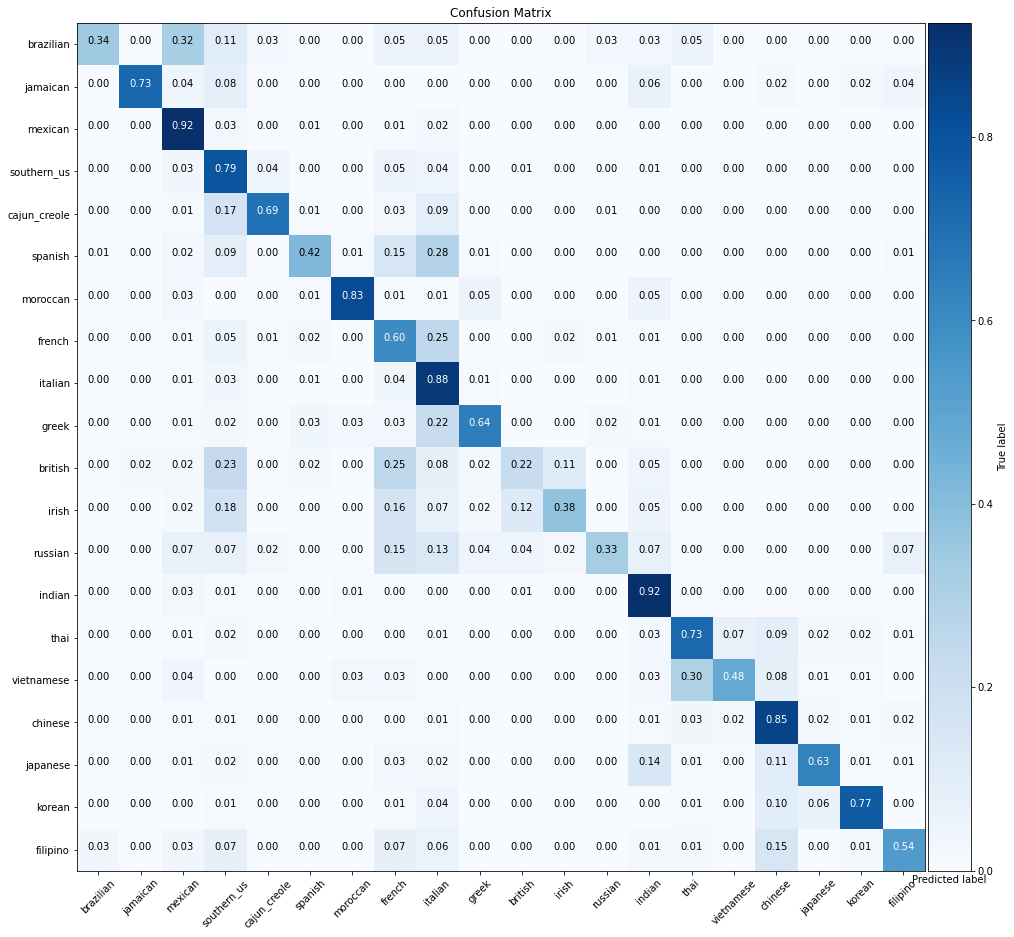

In [50]:
cm = confusion_matrix(y_val.cuisine, predictions, labels)
ml_utils.plot_confusion_matrix(cm, labels, normalize=True, title='Confusion Matrix')

In [61]:
pd.DataFrame(classification_report(y_val.cuisine, predictions, output_dict=True)).T

precision    recall  f1-score      support
brazilian      0.625000  0.394737  0.483871    38.000000
british        0.425000  0.265625  0.326923    64.000000
cajun_creole   0.792453  0.703911  0.745562   179.000000
chinese        0.787072  0.838057  0.811765   247.000000
filipino       0.660714  0.552239  0.601626    67.000000
french         0.555957  0.599222  0.576779   257.000000
greek          0.787234  0.643478  0.708134   115.000000
indian         0.836207  0.917981  0.875188   317.000000
irish          0.552632  0.375000  0.446809    56.000000
italian        0.788506  0.879487  0.831515   780.000000
jamaican       0.853659  0.729167  0.786517    48.000000
japanese       0.801802  0.631206  0.706349   141.000000
korean         0.826667  0.765432  0.794872    81.000000
mexican        0.904478  0.920973  0.912651   658.000000
moroccan       0.821918  0.800000  0.810811    75.000000
russian        0.533333  0.347826  0.421053    46.000000
southern_us    0.707265  0.782506  0.742985   423.000000
spanish        0.606557  0.415730  0.493333    89.000000
thai           0.715278  0.725352  0.720280   142.000000
vietnamese     0.706897  0.532468  0.607407    77.000000
accuracy       0.771282  0.771282  0.771282     0.771282
macro avg      0.714431  0.641020  0.670221  3900.000000
weighted avg   0.766004  0.771282  0.765118  3900.000000

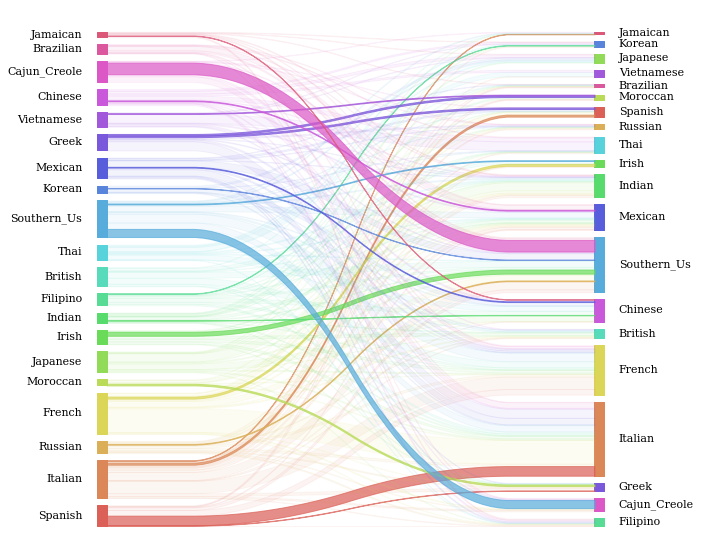

In [130]:
cm = confusion_matrix(y_val.cuisine, predictions)
ml_utils.plot_flow_chart(y_val.cuisine, predictions, cm, labels= labels, normed=False )

In [53]:
##get most distinct features
pd.set_option('display.max_rows', None)
coef = classifier.named_steps['classifier'].coef_
labs = classifier.named_steps['classifier'].classes_

df_dist = None
for i, cus in enumerate(labs):
    top_features = [X_val.columns.values[id] for id in np.argsort(-coef[i,:])[:20]]
    dist_ing_df_i = pd.DataFrame(data= {'Cuisine': cus,
                                     'Most Distinctive Feature': top_features[:10]})
    df_dist = dist_ing_df_i if df_dist is None else pd.concat([df_dist, dist_ing_df_i])
df_dist.set_index(['Cuisine'])
df_dist

Cuisine  Most Distinctive Feature
0     brazilian                   cachaca
1     brazilian             tapioca flour
2     brazilian               almond milk
3     brazilian            dri black bean
4     brazilian              condens milk
5     brazilian            tapioca starch
6     brazilian             shred coconut
7     brazilian                dri shrimp
8     brazilian                    starch
9     brazilian              coconut milk
0       british              malt vinegar
1       british               doubl cream
2       british                  pit date
3       british           beef tenderloin
4       british               dri currant
5       british            brussel sprout
6       british              golden syrup
7       british             raspberri jam
8       british                 mix spice
9       british                      date
0  cajun_creole              creol season
1  cajun_creole              cajun season
2  cajun_creole             creol mustard
3  cajun_creole                  red bean
4  cajun_creole            andouil sausag
5  cajun_creole              smoke sausag
6  cajun_creole              genoa salami
7  cajun_creole                   sprinkl
8  cajun_creole                      okra
9  cajun_creole                 cook rice
0       chinese       szechwan peppercorn
1       chinese              chines spice
2       chinese            mandarin orang
3       chinese          egg roll wrapper
4       chinese         glutin rice flour
5       chinese           chow mein noodl
6       chinese            wonton wrapper
7       chinese               hoisin sauc
8       chinese             dark soy sauc
9       chinese          chines rice wine
0      filipino                pork belli
1      filipino                  cook oil
2      filipino               shrimp past
3      filipino              green papaya
4      filipino          whole peppercorn
5      filipino         glutin rice flour
6      filipino                sweet rice
7      filipino       spring roll wrapper
8      filipino               glutin rice
9      filipino              coconut milk
0        french              gruyer chees
1        french               swiss chees
2        french              haricot vert
3        french           herb de provenc
4        french                    cognac
5        french                   calvado
6        french         shred swiss chees
7        french               grate chees
8        french                brie chees
9        french               pearl onion
0         greek                feta chees
1         greek              greek yogurt
2         greek              greek season
3         greek  greek style plain yogurt
4         greek              phyllo dough
5         greek        plain greek yogurt
6         greek                    tahini
7         greek                      lamb
8         greek                fresh dill
9         greek               leg of lamb
0        indian                     curri
1        indian                    masala
2        indian              garam masala
3        indian              plain yogurt
4        indian                    yogurt
5        indian                  cardamom
6        indian                   chutney
7        indian        green cardamom pod
8        indian              cardamom pod
9        indian    plain wholemilk yogurt
0         irish       irish cream liqueur
1         irish                   whiskey
2         irish                 corn beef
3         irish              beef brisket
4         irish               mash potato
5         irish                     stout
6         irish                      beer
7         irish         whole wheat flour
8         irish              pearl barley
9         irish                    potato
0       italian                   polenta
1       italian                   gnocchi
2       italian                 mascarpon
3       italian              marsala wine
4       italian   